In [1]:
import random
import warnings
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import matplotlib.dates as mdates
from scipy.stats import pearsonr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.inspection import permutation_importance
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber


# Warnings configuration
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
warnings.filterwarnings("ignore", category=FutureWarning, message=".*np\\.object.*")
warnings.filterwarnings("ignore", message=".*sklearn.utils.parallel.delayed.*")
warnings.filterwarnings("ignore", message=".*Do not pass an `input_shape`.*")
warnings.filterwarnings("ignore", message="`sklearn.utils.parallel.delayed` should be used with")
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
os.environ["PYTHONWARNINGS"] = "ignore::UserWarning:sklearn.utils.parallel"


# Helper
def set_global_seed(seed=1234):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

def make_sequences(X_2d, y_1d, window):
    X_seq, y_seq = [], []
    for t in range(window, len(X_2d)):
        X_seq.append(X_2d[t-window:t, :])
        y_seq.append(y_1d[t])
    return np.array(X_seq), np.array(y_seq)

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

/opt/miniconda3/envs/py/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


# Dataset Cleaning

# Step 1: Preprocess the main dataset

### Building a clean Bloomberg dataframe

Here we load the raw Excel export, reconstruct meaningful column names, and get a tidy time series.

In [2]:
# Read the raw file without headers
raw = pd.read_excel("c1data.xlsx", header=None)

# Grab the three header rows (the ones with C 1 Comdty / Last Price / PX_LAST)
header_rows = raw.iloc[3:6]      # rows 3,4,5 in pandas

# Row 3: product group (C 1 Comdty, C 2 Comdty, USDMD1 US Index, …)
group = header_rows.iloc[0].ffill()

# Row 5: Bloomberg field codes (PX_LAST, PX_LOW, VOLATILITY_30D, …)
field = header_rows.iloc[2]

# Build nice column names
cols = []
for g, f in zip(group, field):
    if pd.isna(f):
        # columns that have no field code, we can drop later
        print('a column is na')
        cols.append(None)
        continue

    f_str = str(f).strip()

    if f_str.lower() == "dates":
        cols.append("DATE")
    else:
        if pd.isna(g):
            # no group, just use the field
            cols.append(f_str)
        else:
            g_str = str(g).strip().replace(" ", "_")
            cols.append(f"{g_str}_{f_str}")

# Take the data rows (everything from row 6 down) and apply the new columns
data = raw.iloc[6:].copy()
data.columns = cols

# Drop unnamed / empty columns (where we set None)
data = data.loc[:, [c is not None for c in cols]]

# Parse the date and set as index
data["DATE"] = pd.to_datetime(data["DATE"])
df_c1 = data.set_index("DATE").sort_index()

df_c1.head()

,C_1_Comdty_PX_LAST,C_1_Comdty_PX_LOW,C_1_Comdty_PX_HIGH,C_1_Comdty_PX_OPEN,C_1_Comdty_PX_VOLUME,C_1_Comdty_VOLATILITY_30D,C_1_Comdty_MOV_AVG_30D,C_1_Comdty_OPEN_INT,C_1_Comdty_VOLATILITY_10D,C_1_Comdty_VOLATILITY_60D,...,USDMD1_US_Index_OPEN_INT,USDMD1_US_Index_VOLATILITY_10D,USDMD1_US_Index_VOLATILITY_60D,USDMD1_US_Index_MOV_AVG_10D,USDMD1_US_Index_MOV_AVG_60D,USDMD1_US_Index_30DAY_IMPVOL_100.0%MNY_DF,USDMD1_US_Index_1M_PUT_IMP_VOL_25DELTA_DFLT,USDMD1_US_Index_1M_CALL_IMP_VOL_25DELTA_DFLT,USDMD1_US_Index_2M_CALL_IMP_VOL_25DELTA_DFLT,USDMD1_US_Index_2M_PUT_IMP_VOL_25DELTA_DFLT
DATE,,,,,,,,,,,,,,,,,,,,,
2000-01-03,200.75,200.5,205.75,204.5,45463,34.8125,193.28,213948,58.4375,25.75,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,203,200.75,203.5,200.75,35327,34.875,193.56,213371,15.1875,25.875,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05,203,201,203.25,202.5,30219,34.875,193.91,214820,14.0625,25.6875,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-06,203.75,203,205.75,203,37490,34.875,194.29,216368,14.0625,25.6875,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-07,207,202.5,207.75,203.25,46637,34.875,194.73,219250,16.75,25.9375,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Extract instruments from the group row 
instrument_list = list(dict.fromkeys(str(x).strip().replace(" ", "_") 
                                     for x in group if pd.notna(x)))

print("Detected instruments:")
for inst in instrument_list:
    print(" -", inst)

Detected instruments:
 - C_1_Comdty
 - C_2_Comdty
 - CL1_Comdty
 - DXY_Curncy
 - USGG1M_Index
 - USGG3M_Index
 - USGGBE10_Index
 - HARVCORN_Index
 - GRINCORN_Index
 - CUSEENDS_Index
 - GCFPNPKI_Index
 - ZC1_Comdty
 - CORN_US_Equity
 - NDVIIACN_Index
 - NDVIILCN_Index
 - NDVIINCN_Index
 - NDVIKSCN_Index
 - NDVIMICN_Index
 - NDVIMOCN_Index
 - NDVINDCN_Index
 - NDVINECN_Index
 - NDVIOHCN_Index
 - NDVISDCN_Index
 - NDVIWICN_Index
 - USDMD1_US_Index


In [4]:
# Drop all-NaN columns (no data across entire sample)

# Identify columns with no data at all (all NaN)
empty_cols = df_c1.columns[df_c1.isna().all()].tolist()
print(f"Number of columns weithout data at all: {len(empty_cols)}")

# Drop them
df_c1_clean = df_c1.drop(columns=empty_cols)

# Check remaining columns count
print("\nNumber of columns before:", df_c1.shape[1])
print("Number of columns after:", df_c1_clean.shape[1])

Number of columns weithout data at all: 197

Number of columns before: 476
Number of columns after: 279


In [5]:
### Goal : find a good cutting treshold to maximize data for LSTM and features start date tradeoff (since they don't all begin at the same time) 

# Compute first valid date per column
first_valid = df_c1_clean.apply(lambda col: col.first_valid_index())

rows = []

def get_instrument(col):
    parts = col.split("_")
    if "Comdty" in parts:
        j = parts.index("Comdty")
        return "_".join(parts[:j+1])
    if "Index" in parts:
        j = parts.index("Index")
        return "_".join(parts[:j+1])
    return "_".join(parts[:-1]) if len(parts) > 1 else parts[0]

instrument_map = {col: get_instrument(col) for col in df_c1_clean.columns}

for instrument in sorted(set(instrument_map.values())):
    # columns belonging to this instrument
    cols = [c for c in df_c1_clean.columns if instrument_map[c] == instrument]
    
    # drop columns with no data at all
    fv = first_valid[cols].dropna()

    if fv.empty:
        continue

    # earliest metric
    earliest_metric = fv.idxmin()
    earliest_date = fv.min()

    # latest metric
    latest_metric = fv.idxmax()
    latest_date = fv.max()

    rows.append({
        "instrument": instrument,
        "n_metrics": len(cols),
        "first_metric": earliest_metric,
        "first_metric_date": earliest_date,
        "last_metric": latest_metric,
        "last_metric_date": latest_date
    })

instrument_summary = pd.DataFrame(rows).sort_values("first_metric_date").reset_index(drop=True)

instrument_summary


,instrument,n_metrics,first_metric,first_metric_date,last_metric,last_metric_date
0,CL1_Comdty,15,CL1_Comdty_PX_LAST,2000-01-03,CL1_Comdty_30DAY_IMPVOL_100.0%MNY_DF,2005-10-28
1,USGG3M_Index,11,USGG3M_Index_PX_LAST,2000-01-03,USGG3M_Index_PX_VOLUME,2014-03-12
2,HARVCORN_Index,4,HARVCORN_Index_PX_LAST,2000-01-03,HARVCORN_Index_MOV_AVG_60D,2004-10-15
3,USGGBE10_Index,11,USGGBE10_Index_PX_LAST,2000-01-03,USGGBE10_Index_PX_VOLUME,2014-03-12
4,DXY_Curncy_VOLATILITY,3,DXY_Curncy_VOLATILITY_30D,2000-01-03,DXY_Curncy_VOLATILITY_30D,2000-01-03
5,DXY_Curncy_PX,4,DXY_Curncy_PX_LAST,2000-01-03,DXY_Curncy_PX_LAST,2000-01-03
6,DXY_Curncy_MOV_AVG,3,DXY_Curncy_MOV_AVG_30D,2000-01-03,DXY_Curncy_MOV_AVG_30D,2000-01-03
7,C_2_Comdty,15,C_2_Comdty_PX_LAST,2000-01-03,C_2_Comdty_30DAY_IMPVOL_100.0%MNY_DF,2005-10-28
8,C_1_Comdty,15,C_1_Comdty_PX_LAST,2000-01-03,C_1_Comdty_30DAY_IMPVOL_100.0%MNY_DF,2005-10-28
9,GRINCORN_Index,4,GRINCORN_Index_PX_LAST,2000-01-03,GRINCORN_Index_MOV_AVG_60D,2000-06-01


### Step 1 conclusion

I first inspected when each feature becomes available by computing the first valid observation date for every column and summarizing this information by instrument. This allowed me to see how the effective start date of the dataset changes depending on which futures and volatility series are included.

Based on this inspection, I chose 2005-10-28 as the dataset start date, which is the earliest date where all futures and volatility features for C_1 Comdty and C_2 Comdty are consistently available. Although ZC1_Comdty starts later (late 2006), including it would significantly shorten the sample while adding little incremental information relative to C_1 and C_2. I therefore exclude ZC1_Comdty and keep the longer dataset, which is more suitable for training sequence models.

Features that start later, such as NDVI and other satellite or weather variables, are handled separately and analyzed through ablation studies.

# Step 2 : Engineer basic market features

I keep a full copy of the dataset (df_full) for later ablation studies. I then apply the cutoff date (2005-10-28) to build df_main, and I remove any feature columns that still contain missing values after the cutoff so the main modeling dataset is fully populated.

In [6]:
# DATA ENGINEERING: (EXPANDING WINDOW REGIMES)
MIN_PERIODS = 252 
rv_col = "C_1_Comdty_VOLATILITY_30D"
# Calculate Expanding Quantiles
expand_low  = df_c1_clean[rv_col].expanding(min_periods=MIN_PERIODS).quantile(0.25)
expand_high = df_c1_clean[rv_col].expanding(min_periods=MIN_PERIODS).quantile(0.75)
# Create Regime Flags
df_c1_clean["regime_vol_low"]   = (df_c1_clean[rv_col] <= expand_low).astype(int)
df_c1_clean["regime_vol_high"]  = (df_c1_clean[rv_col] >= expand_high).astype(int)
# Create the -1/0/+1 State
df_c1_clean["regime_vol_state"] = 0
df_c1_clean.loc[df_c1_clean[rv_col] <= expand_low,  "regime_vol_state"] = -1
df_c1_clean.loc[df_c1_clean[rv_col] >= expand_high, "regime_vol_state"] = 1
# DATA ENGINEERING ROLLING WINDOW BEFORE THE CUTOFF (to maximize data) END


# Keep a copy of the full dataset for later ablation studies
df_full = df_c1_clean.copy()



# Define cutoff date
cutoff_date = pd.Timestamp("2005-10-28")

# Apply the cutoff
df_main = df_c1_clean[df_c1_clean.index >= cutoff_date].copy()

print("Shape before dropping NaN columns:", df_main.shape)

# Drop all columns that contain ANY NaNs after cutoff
cols_with_nan = df_main.columns[df_main.isna().any()].tolist()
df_main = df_main.drop(columns=cols_with_nan)

print("Dropped columns due to NaN:", len(cols_with_nan))
print("Remaining columns:", df_main.shape[1])
print("Final dataset shape:", df_main.shape)

# df_full = full dataset (2000–2025, all columns, for ablation studies)
# df_main = trimmed dataset (post-2005, no NaN columns)


Shape before dropping NaN columns: (5244, 282)
Dropped columns due to NaN: 174
Remaining columns: 108
Final dataset shape: (5244, 108)


Starting from df_main, I engineer a first set of market features (returns or rate changes, C1–C2 spread, options skew metrics, and VRP). I also define the prediction target as Bloomberg 30D realized volatility shifted 21 trading days ahead (Target_RV30) and drop the final 21 rows where this target is not available.

In [7]:
# Start from the cleaned trimmed dataset
df = df_main.copy()

# Convert all object columns to numeric (for modeling)
obj_cols = df.select_dtypes(include=["object"]).columns

for c in obj_cols:
    try:
        # Try strict conversion first
        df[c] = pd.to_numeric(df[c], errors="raise")
    except Exception as e:
        print(f"Non-numeric values found in {c}, coercing to NaN. Error: {e}")
        df[c] = pd.to_numeric(df[c], errors="coerce")



# Aliases for key columns
C1_PX   = "C_1_Comdty_PX_LAST"
C2_PX   = "C_2_Comdty_PX_LAST"

C1_IV30 = "C_1_Comdty_30DAY_IMPVOL_100.0%MNY_DF"
C2_IV30 = "C_2_Comdty_30DAY_IMPVOL_100.0%MNY_DF"

C1_RV30_BBG = "C_1_Comdty_VOLATILITY_30D"
C2_RV30_BBG = "C_2_Comdty_VOLATILITY_30D"

C1_IV25C = "C_1_Comdty_1M_CALL_IMP_VOL_25DELTA_DFLT"
C1_IV25P = "C_1_Comdty_1M_PUT_IMP_VOL_25DELTA_DFLT"
C2_IV25C = "C_2_Comdty_1M_CALL_IMP_VOL_25DELTA_DFLT"
C2_IV25P = "C_2_Comdty_1M_PUT_IMP_VOL_25DELTA_DFLT"

# This is the RV we will forecast and use in VRP
TARGET_RV30_COL = C1_RV30_BBG   # Bloomberg 30D HV on C1

# Simple returns for main prices
price_cols = [
    C1_PX, C2_PX,
    "CL1_Comdty_PX_LAST",
    "DXY_Curncy_PX_LAST",
    "USGG1M_Index_PX_LAST",
    "USGG3M_Index_PX_LAST",
    "USGGBE10_Index_PX_LAST",
    "HARVCORN_Index_PX_LAST",
    "GRINCORN_Index_PX_LAST",
    "CUSEENDS_Index_PX_LAST",
    "GCFPNPKI_Index_PX_LAST",
    "USDMD1_US_Index_PX_LAST",
]

rate_cols = ["USGG1M_Index_PX_LAST", "USGG3M_Index_PX_LAST"]

for col in price_cols:
    if col not in df.columns:
        continue

    prefix = col.replace("_PX_LAST", "")
    s = df[col].astype(float)

    if col in rate_cols:
        # short rates: use level changes, not pct returns
        df[f"{prefix}_chg"] = s.diff()
    else:
        df[f"{prefix}_ret"] = s.pct_change()



# Calendar spreads C1 – C2
if C1_PX in df.columns and C2_PX in df.columns:
    df["C1_C2_spread"]     = df[C1_PX].astype(float) - df[C2_PX].astype(float)
    df["C1_C2_spread_pct"] = df["C1_C2_spread"] / df[C2_PX].astype(float)
    df["C1_C2_spread_chg"] = df["C1_C2_spread"].diff()

# IV skew and butterfly (RR25, BF25) for C1 and C2
def add_skew_block(iv_atm, iv_call25, iv_put25, tag):
    if all(col in df.columns for col in [iv_atm, iv_call25, iv_put25]):
        atm    = df[iv_atm].astype(float)
        call25 = df[iv_call25].astype(float)
        put25  = df[iv_put25].astype(float)

        df[f"{tag}_RR25"] = call25 - put25                      # risk reversal
        df[f"{tag}_BF25"] = 0.5 * (call25 + put25) - atm        # butterfly

        df[f"{tag}_RR25_rel"] = df[f"{tag}_RR25"] / atm
        df[f"{tag}_BF25_rel"] = df[f"{tag}_BF25"] / atm

add_skew_block(C1_IV30, C1_IV25C, C1_IV25P, "C1")
add_skew_block(C2_IV30, C2_IV25C, C2_IV25P, "C2")



# Volatility risk premium (VRP = IV30 - Bloomberg RV30)
if C1_IV30 in df.columns and C1_RV30_BBG in df.columns:
    df["C1_VRP30"] = df[C1_IV30].astype(float) - df[C1_RV30_BBG].astype(float)

if C2_IV30 in df.columns and C2_RV30_BBG in df.columns:
    df["C2_VRP30"] = df[C2_IV30].astype(float) - df[C2_RV30_BBG].astype(float)



# VRP REGIME
# Define the burn-in period
BURN_IN_DAYS = 63  
# Calculate Expanding Quantiles on the available data (post-cutoff)
vrp_expand_low  = df["C1_VRP30"].expanding(min_periods=1).quantile(0.25)
vrp_expand_high = df["C1_VRP30"].expanding(min_periods=1).quantile(0.75)
# Create the Flags (initially noisy)
df["regime_vrp_low"]   = (df["C1_VRP30"] <= vrp_expand_low).astype(int)
df["regime_vrp_high"]  = (df["C1_VRP30"] >= vrp_expand_high).astype(int)
# Create the State
df["regime_vrp_state"] = 0
df.loc[df["C1_VRP30"] <= vrp_expand_low,  "regime_vrp_state"] = -1
df.loc[df["C1_VRP30"] >= vrp_expand_high, "regime_vrp_state"] = 1
# THE FIX: Overwrite the "Burn-In" period with Neutral (0)
df.iloc[:BURN_IN_DAYS, df.columns.get_loc("regime_vrp_low")] = 0
df.iloc[:BURN_IN_DAYS, df.columns.get_loc("regime_vrp_high")] = 0
df.iloc[:BURN_IN_DAYS, df.columns.get_loc("regime_vrp_state")] = 0


# Forecast horizon in trading days
H_FWD = 21

# Define the forecasting target: Bloomberg 30D RV H_FWD days ahead
df["Target_RV30"] = df[C1_RV30_BBG].astype(float).shift(-H_FWD)

# Drop rows where the target is missing (this will remove about the last H_FWD rows)
n_before = df.shape[0]
df = df[df["Target_RV30"].notna()].copy()
n_after = df.shape[0]
print(f"Rows before: {n_before}, rows after: {n_after}, dropped: {n_before - n_after}")

Rows before: 5244, rows after: 5223, dropped: 21


I add simple seasonality features from the calendar. I extract month and day-of-week, encode month cyclically using sine/cosine, and create coarse agronomic season dummies for U.S. corn (planting, pollination, harvest) based on the month.

In [8]:
# Seasonality from calendar
df["month"]      = df.index.month
df["dayofweek"]  = df.index.dayofweek

# Cyclical encoding of month (useful for models that like continuous features)
df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)

# Agronomic seasons (US Corn)
df["is_planting"]    = df["month"].isin([4, 5]).astype(int)   # Apr–May
df["is_pollination"] = df["month"].isin([6, 7]).astype(int)   # Jun–Jul
df["is_harvest"]     = df["month"].isin([9, 10]).astype(int)  # Sep–Oct

In [9]:
# Explicitly drop the bad return columns if they exist
df = df.drop(columns=[c for c in ["USGG1M_Index_ret", "USGG3M_Index_ret"] if c in df.columns]) # contains NaNs
# Drop the first row (returns undefined there)
df = df.iloc[1:, :].copy()

In this section, I engineer a first set of market and calendar features from the raw Bloomberg data. These include price returns or rate changes, calendar spreads, option-implied skew measures, and the volatility risk premium, as well as basic calendar and agronomic seasonality indicators. I also define the forecasting target as 30-day realized volatility shifted 21 trading days ahead, resulting in a clean, fully aligned dataset ready for exploratory analysis and modeling.

---
# Explanatory Data Analysis

In [10]:
# Corn futures prices plot

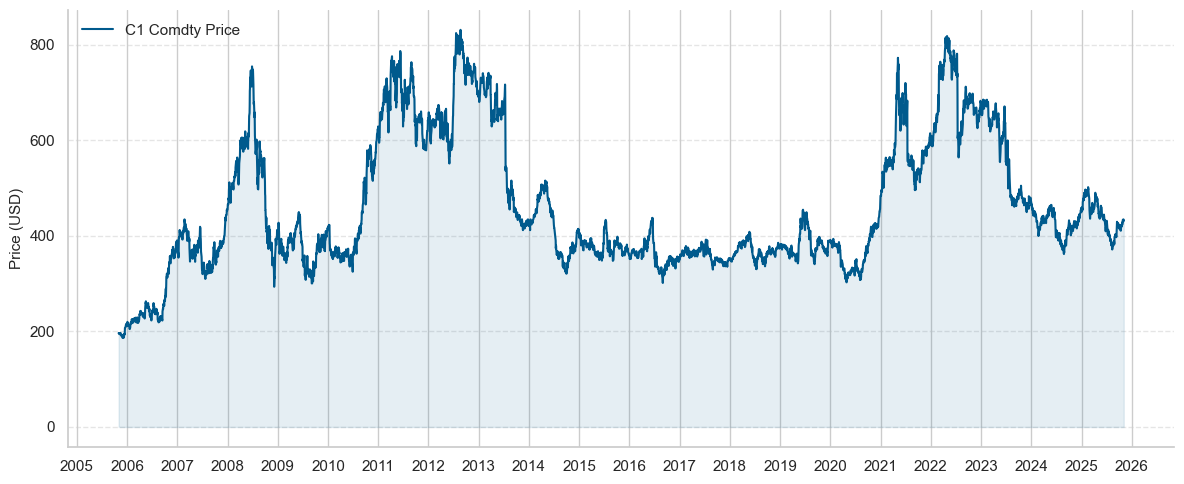

In [11]:
prices = df["C_1_Comdty_PX_LAST"].astype(float).dropna().copy()

sns.set_theme(style="whitegrid", rc={"axes.spines.right": False, "axes.spines.top": False})

plt.figure(figsize=(12, 5))
plt.plot(prices.index, prices, color='#005a8d', linewidth=1.5, label="C1 Comdty Price")
plt.fill_between(prices.index, prices, color='#005a8d', alpha=0.1)

# plt.title("C1 Corn Futures: Close Price", fontsize=14, fontweight='bold', pad=15)
plt.ylabel("Price (USD)", fontsize=11)
plt.legend(loc="upper left", frameon=False)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()

# Save before showing
plt.savefig("figs/c1timeserie.png", dpi=300, bbox_inches='tight')
plt.show()

## Target RV vs IV and Seasonality Analysis

Shape of IV/RV comparison dataset: (5222, 2)

Summary stats:
              IV30   Fwd21_RV30
count  5222.000000  5222.000000
mean     26.934544    27.585935
std       9.139722    11.708069
min       9.625000     8.437500
25%      19.828125    20.000000
50%      25.375000    24.812500
75%      33.000000    32.250000
max      62.062500    85.937500

Correlation matrix:
                IV30  Fwd21_RV30
IV30        1.000000    0.736834
Fwd21_RV30  0.736834    1.000000


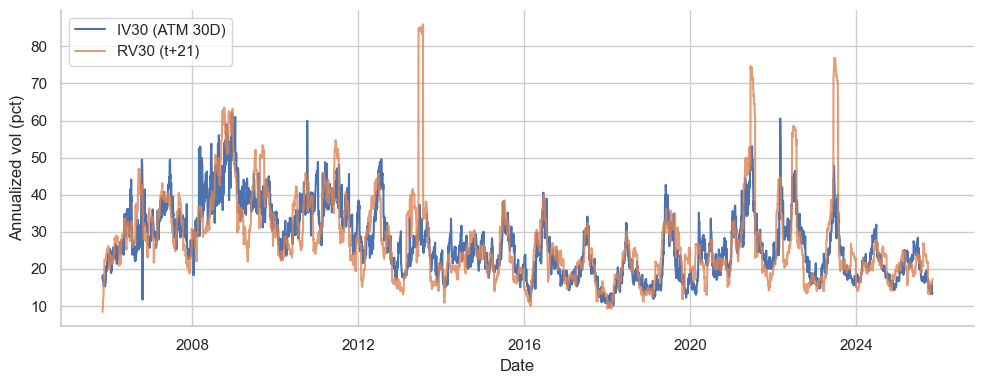

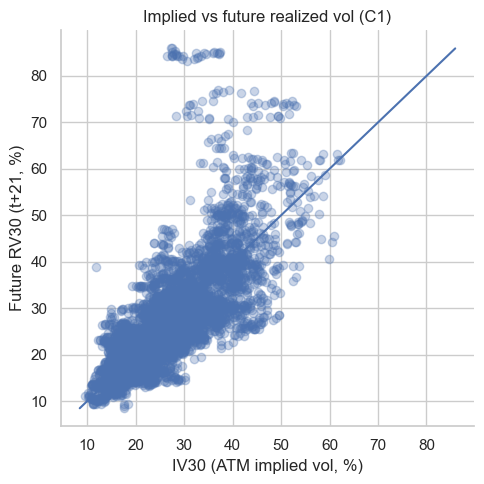

In [12]:
# Build a clean comparison sample
eda = df[[C1_IV30, "Target_RV30"]].astype(float).dropna().copy()
eda = eda.rename(columns={
    C1_IV30: "IV30",
    "Target_RV30": "Fwd21_RV30"
})

print("Shape of IV/RV comparison dataset:", eda.shape)
print("\nSummary stats:")
print(eda.describe())

print("\nCorrelation matrix:")
print(eda.corr())

# Time series plot
plt.figure(figsize=(10, 4))
plt.plot(eda.index, eda["IV30"], label="IV30 (ATM 30D)")
plt.plot(eda.index, eda["Fwd21_RV30"], label="RV30 (t+21)", alpha=0.8)
plt.legend()
# plt.title("C1 Corn futures: IV30 vs 21-day-ahead RV30")
plt.xlabel("Date")
plt.ylabel("Annualized vol (pct)")
plt.tight_layout()
plt.savefig("figs/rvvsiv.png", dpi=300, bbox_inches='tight')
plt.show()

# Scatter plot IV vs future RV
plt.figure(figsize=(5, 5))
plt.scatter(eda["IV30"], eda["Fwd21_RV30"], alpha=0.3)

min_v = eda[["IV30", "Fwd21_RV30"]].min().min()
max_v = eda[["IV30", "Fwd21_RV30"]].max().max()
plt.plot([min_v, max_v], [min_v, max_v])  # 45° line

plt.xlabel("IV30 (ATM implied vol, %)")
plt.ylabel("Future RV30 (t+21, %)")
plt.title("Implied vs future realized vol (C1)")
plt.tight_layout()
plt.show()

Implied volatility is a strong predictor of future realized volatility, with a high positive correlation. Most of the time, IV and future RV move closely together, but there are a few periods with large divergences, notably around 2013, 2021, and 2023, when realized volatility experienced sharp spikes relative to implied volatility.

Shape (aligned IV/Target): (5222, 2)

Summary stats:
       C_1_Comdty_30DAY_IMPVOL_100.0%MNY_DF  Target_RV30
count                           5222.000000  5222.000000
mean                              26.934544    27.585935
std                                9.139722    11.708069
min                                9.625000     8.437500
25%                               19.828125    20.000000
50%                               25.375000    24.812500
75%                               33.000000    32.250000
max                               62.062500    85.937500

Correlation IV vs future RV: 0.7368343082730073


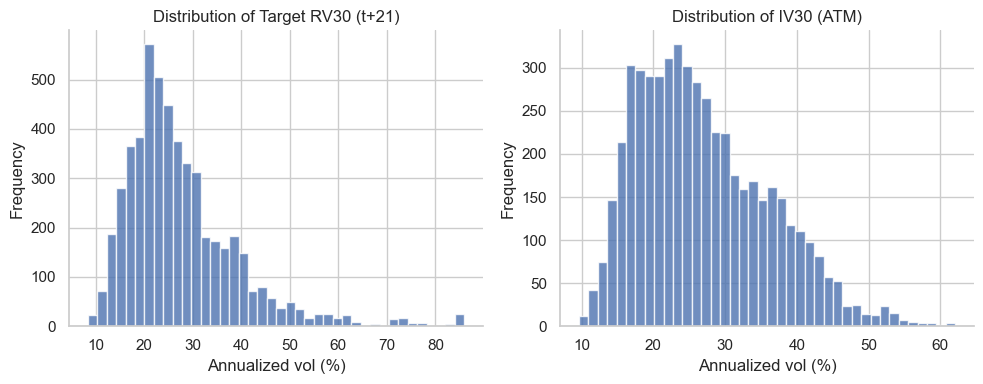

In [13]:
C1_IV30 = "C_1_Comdty_30DAY_IMPVOL_100.0%MNY_DF"

# Align IV and target on common dates
sub = df[[C1_IV30, "Target_RV30"]].dropna().astype(float)
iv  = sub[C1_IV30]
rv  = sub["Target_RV30"]

print("Shape (aligned IV/Target):", sub.shape)
print("\nSummary stats:")
print(sub.describe())
print("\nCorrelation IV vs future RV:", sub.corr().iloc[0, 1])

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Histogram of Target RV
axes[0].hist(rv, bins=40, alpha=0.8)
axes[0].set_title("Distribution of Target RV30 (t+21)")
axes[0].set_xlabel("Annualized vol (%)")
axes[0].set_ylabel("Frequency")

# Histogram of IV
axes[1].hist(iv, bins=40, alpha=0.8)
axes[1].set_title("Distribution of IV30 (ATM)")
axes[1].set_xlabel("Annualized vol (%)")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.savefig("figs/IVRVdistributions.png", dpi=300, bbox_inches='tight')

plt.show()


IV30 and forward RV30 are strongly linked (corr ≈ 0.74), so implied volatility already contains substantial information about future realized volatility. However, the target RV distribution is more right-skewed and exhibits larger extreme outcomes than IV, indicating that large volatility shocks are realized more abruptly than they are priced or updated in implied vol. This motivates models that focus on tail events or regime shifts rather than only improving average fit.

Ex-post VRP summary (IV - future RV):
count    5222.000000
mean       -0.651391
std         7.932108
min       -58.562500
25%        -3.750000
50%         0.187500
75%         3.625000
max        21.125000
Name: VRP_expost, dtype: float64

Share of days with IV > future RV: 0.5093833780160858


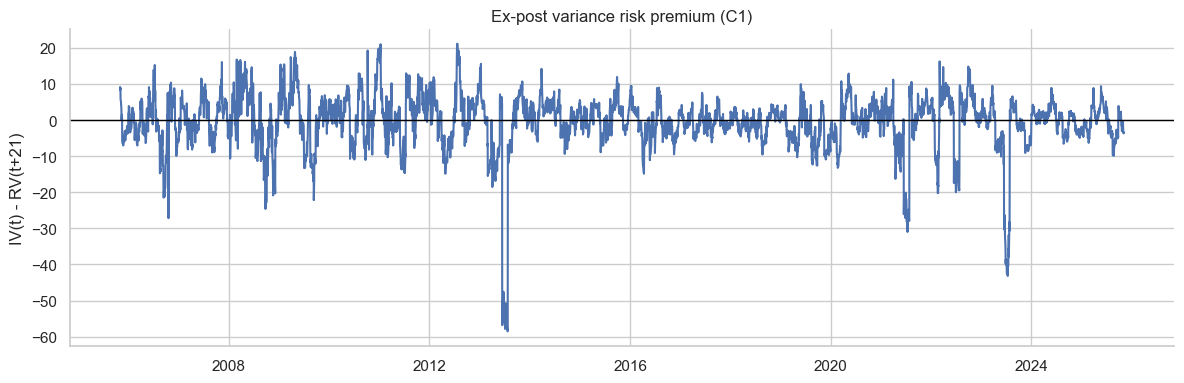

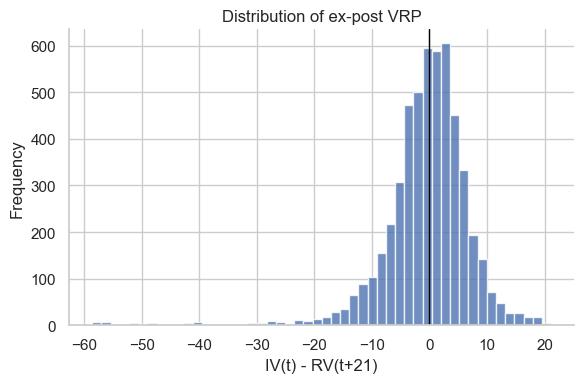

In [14]:
sub = df[[C1_IV30, "Target_RV30"]].dropna().astype(float).copy()
sub["VRP_expost"] = sub[C1_IV30] - sub["Target_RV30"]

print("Ex-post VRP summary (IV - future RV):")
print(sub["VRP_expost"].describe())
print("\nShare of days with IV > future RV:",
      (sub["VRP_expost"] > 0).mean())

# Time-series plot
plt.figure(figsize=(12, 4))
plt.plot(sub.index, sub["VRP_expost"])
plt.axhline(0, color="black", linewidth=1)
plt.ylabel("IV(t) - RV(t+21)")
plt.title("Ex-post variance risk premium (C1)")
plt.tight_layout()
plt.show()

# Distribution
plt.figure(figsize=(6, 4))
plt.hist(sub["VRP_expost"], bins=50, alpha=0.8)
plt.axvline(0, color="black", linewidth=1)
plt.xlabel("IV(t) - RV(t+21)")
plt.ylabel("Frequency")
plt.title("Distribution of ex-post VRP")
plt.tight_layout()
plt.show()


On average IV is close to future RV, but rare realized-vol spikes create a heavy left tail, which is exactly the risk a short-vol strategy must manage.

Aligned sample shape: (5222, 4)

Underpricing stats (RV_fwd21 > IV30)
Share of days with RV_fwd21 > IV30: 48.564%
Avg (RV - IV) conditional on RV>IV: 6.028 vol points
Med (RV - IV) conditional on RV>IV: 3.875 vol points

Quantiles of (RV - IV) when RV>IV:
0.50     3.875000
0.75     7.312500
0.90    12.375000
0.95    17.234375
0.99    47.993750

June–July underpricing stats
June–July sample size: 871
Share of days with RV_fwd21 > IV30 (Jun–Jul): 57.176%
Avg (RV - IV) conditional on RV>IV (Jun–Jul): 11.143 vol points
Med (RV - IV) conditional on RV>IV (Jun–Jul): 5.188 vol points


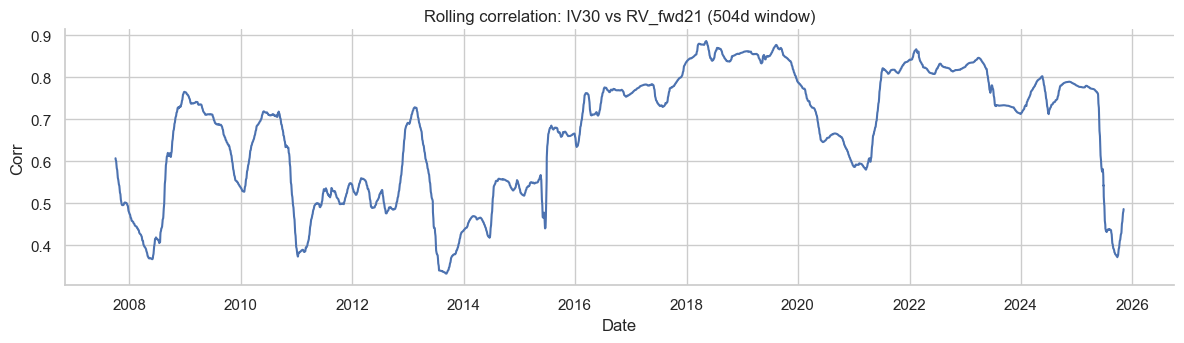

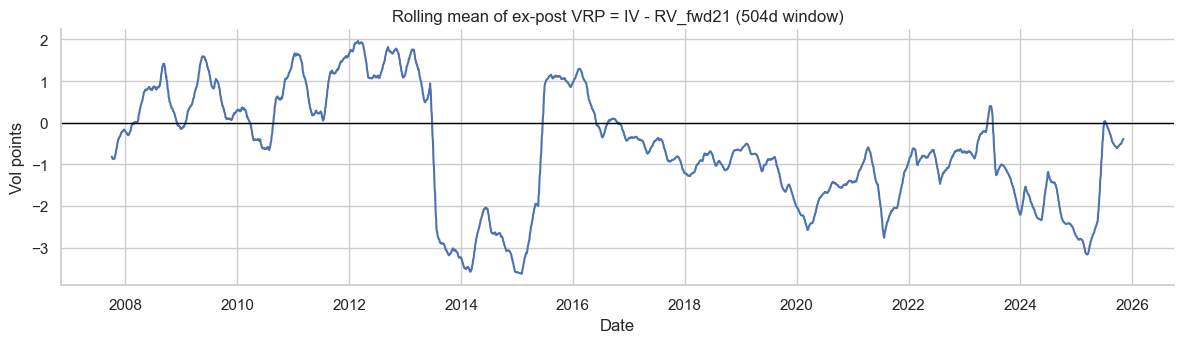

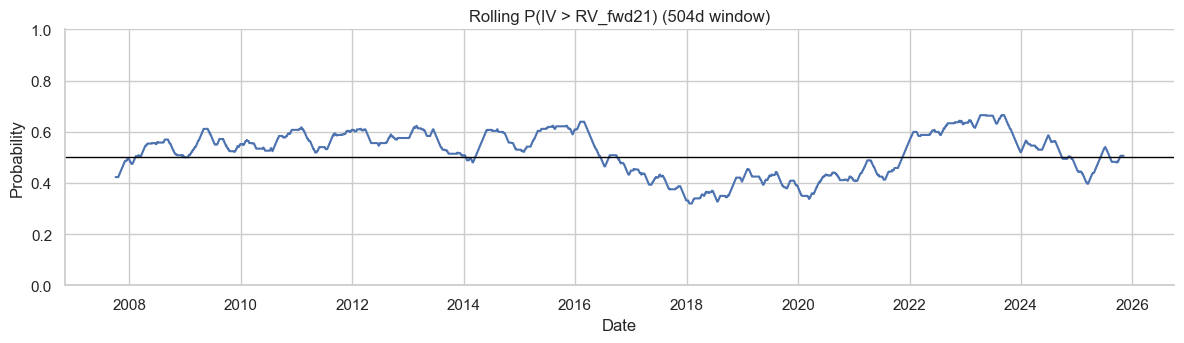

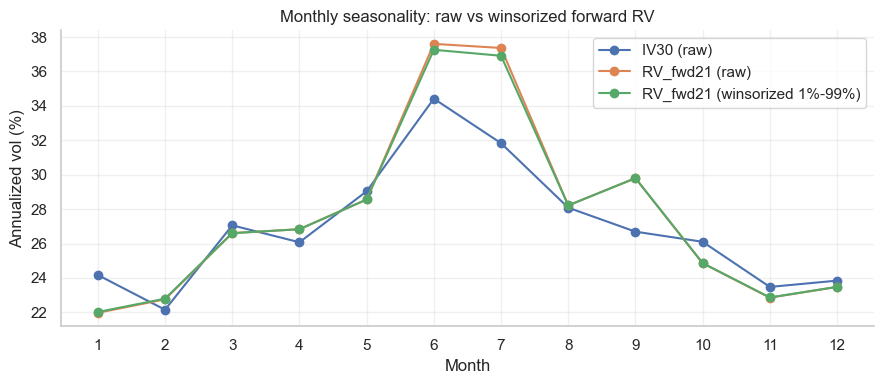

/var/folders/k1/vzsy4xf171nbt2_gwhj1_w4m0000gn/T/ipykernel_96022/496532166.py:99: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


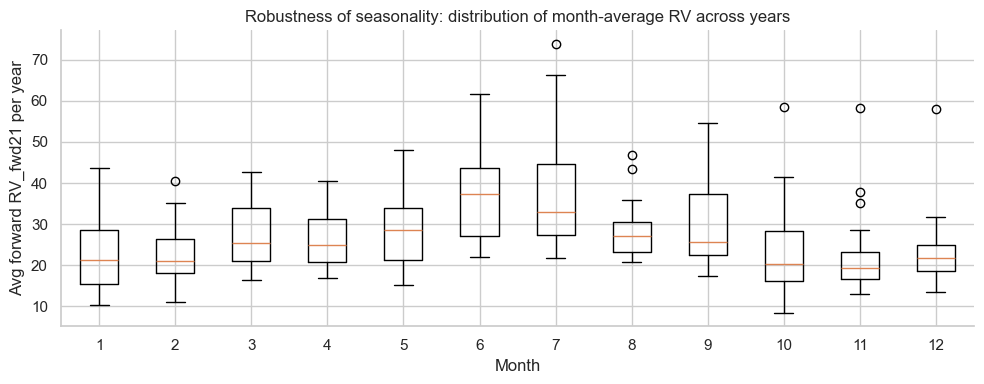


Overpricing stats (IV30 > RV_fwd21)
Share of days with IV30 > RV_fwd21: 50.938%
Avg (IV - RV) conditional on IV>RV: 4.468 vol points
Med (IV - RV) conditional on IV>RV: 3.625 vol points

Quantiles of (IV - RV) when IV>RV:
0.50     3.625000
0.75     6.078125
0.90     9.312500
0.95    11.690625
0.99    17.437500

Unconditional ex-post VRP = IV30 - RV_fwd21
Mean VRP_expost:   -0.651 vol points
Median VRP_expost: 0.188 vol points
Std VRP_expost:    7.932 vol points

Quantiles of VRP_expost (IV - RV_fwd21):
0.01   -30.371875
0.05   -12.246875
0.10    -8.375000
0.25    -3.750000
0.50     0.187500
0.75     3.625000
0.90     6.993750
0.95     9.375000
0.99    15.710625

June–July overpricing stats (IV30 > RV_fwd21)
June–July sample size: 871
Share of days with IV30 > RV_fwd21 (Jun–Jul): 42.365%
Avg (IV - RV) conditional on IV>RV (Jun–Jul): 4.700 vol points
Med (IV - RV) conditional on IV>RV (Jun–Jul): 3.875 vol points

Quantiles of (IV - RV) when IV>RV (Jun–Jul):
0.50     3.8750
0.75     6.31

In [15]:
# Build aligned sample
sub = df[[C1_IV30, "Target_RV30"]].astype(float).copy()
sub = sub.rename(columns={C1_IV30: "IV30", "Target_RV30": "RV_fwd21"})
sub["VRP_expost"] = sub["IV30"] - sub["RV_fwd21"]  # >0 means IV > future RV
sub["underpriced_flag"] = (sub["RV_fwd21"] > sub["IV30"]).astype(int)  # RV > IV

print("Aligned sample shape:", sub.shape)

# Core stats: how often RV(t+21) > IV(t), and magnitude when it happens
p_under = sub["underpriced_flag"].mean()
avg_gap_when_under = (sub.loc[sub["underpriced_flag"] == 1, "RV_fwd21"] - sub.loc[sub["underpriced_flag"] == 1, "IV30"]).mean()
med_gap_when_under = (sub.loc[sub["underpriced_flag"] == 1, "RV_fwd21"] - sub.loc[sub["underpriced_flag"] == 1, "IV30"]).median()

print("\nUnderpricing stats (RV_fwd21 > IV30)")
print(f"Share of days with RV_fwd21 > IV30: {p_under:.3%}")
print(f"Avg (RV - IV) conditional on RV>IV: {avg_gap_when_under:.3f} vol points")
print(f"Med (RV - IV) conditional on RV>IV: {med_gap_when_under:.3f} vol points")

# Severity quantiles when RV > IV
gaps = (sub.loc[sub["underpriced_flag"] == 1, "RV_fwd21"] - sub.loc[sub["underpriced_flag"] == 1, "IV30"])
if len(gaps) > 0:
    q = gaps.quantile([0.5, 0.75, 0.90, 0.95, 0.99])
    print("\nQuantiles of (RV - IV) when RV>IV:")
    print(q.to_string())

# Same stats specifically in June–July
sub["month"] = sub.index.month
jj = sub[sub["month"].isin([6, 7])].copy()

p_under_jj = jj["underpriced_flag"].mean()
avg_gap_under_jj = (jj.loc[jj["underpriced_flag"] == 1, "RV_fwd21"] - jj.loc[jj["underpriced_flag"] == 1, "IV30"]).mean()
med_gap_under_jj = (jj.loc[jj["underpriced_flag"] == 1, "RV_fwd21"] - jj.loc[jj["underpriced_flag"] == 1, "IV30"]).median()

print("\nJune–July underpricing stats")
print("June–July sample size:", len(jj))
print(f"Share of days with RV_fwd21 > IV30 (Jun–Jul): {p_under_jj:.3%}")
print(f"Avg (RV - IV) conditional on RV>IV (Jun–Jul): {avg_gap_under_jj:.3f} vol points")
print(f"Med (RV - IV) conditional on RV>IV (Jun–Jul): {med_gap_under_jj:.3f} vol points")

# Rolling stability diagnostics (2-year rolling window by default)
ROLL = 252 * 2  # ~2 years of trading days
roll_corr = sub["IV30"].rolling(ROLL).corr(sub["RV_fwd21"])
roll_vrp_mean = sub["VRP_expost"].rolling(ROLL).mean()
roll_p_iv_gt_rv = (sub["VRP_expost"] > 0).rolling(ROLL).mean()  # P(IV > future RV)

# Plot rolling measures
plt.figure(figsize=(12, 3.6))
plt.plot(roll_corr)
plt.title(f"Rolling correlation: IV30 vs RV_fwd21 ({ROLL}d window)")
plt.xlabel("Date")
plt.ylabel("Corr")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 3.6))
plt.plot(roll_vrp_mean)
plt.axhline(0, color="black", linewidth=1)
plt.title(f"Rolling mean of ex-post VRP = IV - RV_fwd21 ({ROLL}d window)")
plt.xlabel("Date")
plt.ylabel("Vol points")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 3.6))
plt.plot(roll_p_iv_gt_rv)
plt.axhline(0.5, color="black", linewidth=1)
plt.title(f"Rolling P(IV > RV_fwd21) ({ROLL}d window)")
plt.xlabel("Date")
plt.ylabel("Probability")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# Quick robustness check: monthly means with winsorized RV (cap extremes at 1%/99%)
sub_w = sub.copy()
lo, hi = sub_w["RV_fwd21"].quantile([0.01, 0.99])
sub_w["RV_fwd21_w"] = sub_w["RV_fwd21"].clip(lower=lo, upper=hi)

monthly_raw = sub.groupby(sub.index.month)[["IV30", "RV_fwd21"]].mean()
monthly_w   = sub_w.groupby(sub_w.index.month)[["IV30", "RV_fwd21_w"]].mean()
plt.figure(figsize=(9, 4))
plt.plot(monthly_raw.index, monthly_raw["IV30"], marker="o", label="IV30 (raw)")
plt.plot(monthly_raw.index, monthly_raw["RV_fwd21"], marker="o", label="RV_fwd21 (raw)")
plt.plot(monthly_w.index,   monthly_w["RV_fwd21_w"], marker="o", label="RV_fwd21 (winsorized 1%-99%)")
plt.xticks(range(1, 13))
plt.xlabel("Month")
plt.ylabel("Annualized vol (%)")
plt.title("Monthly seasonality: raw vs winsorized forward RV")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Month-by-year robustness: distribution of month means across years
sub["year"] = sub.index.year
month_year = sub.groupby(["year", "month"])["RV_fwd21"].mean().reset_index()

plt.figure(figsize=(10, 4))
plt.boxplot(
    [month_year.loc[month_year["month"] == m, "RV_fwd21"].dropna().values for m in range(1, 13)],
    labels=list(range(1, 13))
)
plt.xlabel("Month")
plt.ylabel("Avg forward RV_fwd21 per year")
plt.title("Robustness of seasonality: distribution of month-average RV across years")
plt.tight_layout()
plt.show()



# Overpricing stats: IV30 > RV_fwd21
sub["overpriced_flag"] = (sub["IV30"] > sub["RV_fwd21"]).astype(int)  # IV > future RV
p_over = sub["overpriced_flag"].mean()

gap_over = (sub.loc[sub["overpriced_flag"] == 1, "IV30"] - sub.loc[sub["overpriced_flag"] == 1, "RV_fwd21"])
avg_gap_over = gap_over.mean()
med_gap_over = gap_over.median()

print("\nOverpricing stats (IV30 > RV_fwd21)")
print(f"Share of days with IV30 > RV_fwd21: {p_over:.3%}")
print(f"Avg (IV - RV) conditional on IV>RV: {avg_gap_over:.3f} vol points")
print(f"Med (IV - RV) conditional on IV>RV: {med_gap_over:.3f} vol points")

if len(gap_over) > 0:
    q_over = gap_over.quantile([0.5, 0.75, 0.90, 0.95, 0.99])
    print("\nQuantiles of (IV - RV) when IV>RV:")
    print(q_over.to_string())

# Unconditional VRP_expost moments (IV - RV_fwd21)
vrp = sub["VRP_expost"]
print("\nUnconditional ex-post VRP = IV30 - RV_fwd21")
print(f"Mean VRP_expost:   {vrp.mean():.3f} vol points")
print(f"Median VRP_expost: {vrp.median():.3f} vol points")
print(f"Std VRP_expost:    {vrp.std():.3f} vol points")

# Unconditional quantiles
q_vrp = vrp.quantile([0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99])
print("\nQuantiles of VRP_expost (IV - RV_fwd21):")
print(q_vrp.to_string())

# Same overpricing stats specifically in June–July
jj = sub[sub["month"].isin([6, 7])].copy()
jj["overpriced_flag"] = (jj["IV30"] > jj["RV_fwd21"]).astype(int)

p_over_jj = jj["overpriced_flag"].mean()
gap_over_jj = (jj.loc[jj["overpriced_flag"] == 1, "IV30"] - jj.loc[jj["overpriced_flag"] == 1, "RV_fwd21"])
avg_gap_over_jj = gap_over_jj.mean()
med_gap_over_jj = gap_over_jj.median()

print("\nJune–July overpricing stats (IV30 > RV_fwd21)")
print("June–July sample size:", len(jj))
print(f"Share of days with IV30 > RV_fwd21 (Jun–Jul): {p_over_jj:.3%}")
print(f"Avg (IV - RV) conditional on IV>RV (Jun–Jul): {avg_gap_over_jj:.3f} vol points")
print(f"Med (IV - RV) conditional on IV>RV (Jun–Jul): {med_gap_over_jj:.3f} vol points")

if len(gap_over_jj) > 0:
    q_over_jj = gap_over_jj.quantile([0.5, 0.75, 0.90, 0.95, 0.99])
    print("\nQuantiles of (IV - RV) when IV>RV (Jun–Jul):")
    print(q_over_jj.to_string())

# Sanity check: ties (IV == RV) frequency (usually tiny)
ties = (sub["IV30"] == sub["RV_fwd21"]).mean()
print(f"\nSanity check, share of exact ties IV30 == RV_fwd21: {ties:.6%}")

Unconditionally, IV and forward RV are close on average, but the distribution is asymmetric: rare large RV>IV episodes dominate downside.

In June–July, the market is more often in the “RV ends up above IV” state (57% of days) and the conditional gap is much larger (avg ~11 vol points). That’s strong evidence of seasonal stress risk in corn.

Rolling plots confirm the relationship is not stable through time, so a model that works in one regime may degrade in another.

In [16]:
sub2 = sub.copy()
if "year" not in sub2.columns:
    sub2["year"] = sub2.index.year
if "month" not in sub2.columns:
    sub2["month"] = sub2.index.month

# Ensure flags exist
sub2["rv_gt_iv"] = (sub2["RV_fwd21"] > sub2["IV30"]).astype(int)
sub2["iv_gt_rv"] = (sub2["IV30"] > sub2["RV_fwd21"]).astype(int)

# Helper: summarize stats for a given dataframe slice
def summarize_block(df_in: pd.DataFrame, label: str):
    out = {}
    out["label"] = label
    out["n"] = len(df_in)

    # Frequencies
    out["P(RV>IV)"] = df_in["rv_gt_iv"].mean()
    out["P(IV>RV)"] = df_in["iv_gt_rv"].mean()

    # Unconditional VRP moments
    out["VRP_mean"] = df_in["VRP_expost"].mean()
    out["VRP_median"] = df_in["VRP_expost"].median()

    # Tail risk on the dangerous side: RV - IV conditional on RV>IV
    g_under = (df_in.loc[df_in["rv_gt_iv"] == 1, "RV_fwd21"] - df_in.loc[df_in["rv_gt_iv"] == 1, "IV30"])
    out["(RV-IV)|RV>IV_mean"] = g_under.mean() if len(g_under) else np.nan
    out["(RV-IV)|RV>IV_p95"]  = g_under.quantile(0.95) if len(g_under) else np.nan
    out["(RV-IV)|RV>IV_p99"]  = g_under.quantile(0.99) if len(g_under) else np.nan

    # Tail on the “good” side: IV - RV conditional on IV>RV
    g_over = (df_in.loc[df_in["iv_gt_rv"] == 1, "IV30"] - df_in.loc[df_in["iv_gt_rv"] == 1, "RV_fwd21"])
    out["(IV-RV)|IV>RV_mean"] = g_over.mean() if len(g_over) else np.nan
    out["(IV-RV)|IV>RV_p95"]  = g_over.quantile(0.95) if len(g_over) else np.nan
    out["(IV-RV)|IV>RV_p99"]  = g_over.quantile(0.99) if len(g_over) else np.nan

    return out

# By-year table (focus on 2012–2013 but show all years)
year_rows = []
for y, g in sub2.groupby("year"):
    if len(g) < 100:
        continue
    year_rows.append(summarize_block(g, label=str(y)))

year_tbl = pd.DataFrame(year_rows).sort_values("label").reset_index(drop=True)


# Highlight 2012–2013 quickly (if present)
focus_years = year_tbl[year_tbl["label"].isin(["2012", "2013"])]
if len(focus_years):
    print("\nFocus: 2012–2013")
    display(focus_years)

# Sensitivity: exclude top 1% RV_fwd21 days (global threshold)
thr_99 = sub2["RV_fwd21"].quantile(0.99)
sub_ex = sub2[sub2["RV_fwd21"] <= thr_99].copy()

print(f"\nTop 1% RV_fwd21 threshold (99th pct): {thr_99:.3f}")
print("Original n:", len(sub2), "| Excluding top 1% n:", len(sub_ex))

# Summaries: full sample vs excluded-top-1%
full_row = summarize_block(sub2, label="FULL")
excl_row = summarize_block(sub_ex, label="EXCL_TOP1_RV")

sens_tbl = pd.DataFrame([full_row, excl_row])

print("\nSensitivity table: full vs excluding top 1% RV_fwd21")
display(sens_tbl)

# 3) (Optional) Repeat sensitivity specifically for June–July
jj_full = sub2[sub2["month"].isin([6, 7])].copy()
jj_ex   = sub_ex[sub_ex["month"].isin([6, 7])].copy()

jj_tbl = pd.DataFrame([
    summarize_block(jj_full, label="JJ_FULL"),
    summarize_block(jj_ex,   label="JJ_EXCL_TOP1_RV")
])

print("\nJune–July sensitivity: full vs excluding top 1% RV_fwd21")
display(jj_tbl)



Focus: 2012–2013


,label,n,P(RV>IV),P(IV>RV),VRP_mean,VRP_median,(RV-IV)|RV>IV_mean,(RV-IV)|RV>IV_p95,(RV-IV)|RV>IV_p99,(IV-RV)|IV>RV_mean,(IV-RV)|IV>RV_p95,(IV-RV)|IV>RV_p99
6,2012,261,0.417625,0.578544,1.520115,1.8125,5.524083,12.0750,14.1425,6.615066,17.781250,20.93750
7,2013,261,0.532567,0.452107,-7.463362,-0.6875,18.293165,56.8125,58.2625,5.040784,11.778125,14.66625



Top 1% RV_fwd21 threshold (99th pct): 73.612
Original n: 5222 | Excluding top 1% n: 5169

Sensitivity table: full vs excluding top 1% RV_fwd21


,label,n,P(RV>IV),P(IV>RV),VRP_mean,VRP_median,(RV-IV)|RV>IV_mean,(RV-IV)|RV>IV_p95,(RV-IV)|RV>IV_p99,(IV-RV)|IV>RV_mean,(IV-RV)|IV>RV_p95,(IV-RV)|IV>RV_p99
0,FULL,5222,0.485638,0.509383,-0.651391,0.1875,6.028169,17.234375,47.99375,4.468374,11.690625,17.4375
1,EXCL_TOP1_RV,5169,0.480364,0.514606,-0.207971,0.2500,5.219845,14.312500,26.25000,4.468374,11.690625,17.4375



June–July sensitivity: full vs excluding top 1% RV_fwd21


,label,n,P(RV>IV),P(IV>RV),VRP_mean,VRP_median,(RV-IV)|RV>IV_mean,(RV-IV)|RV>IV_p95,(RV-IV)|RV>IV_p99,(IV-RV)|IV>RV_mean,(IV-RV)|IV>RV_p95,(IV-RV)|IV>RV_p99
0,JJ_FULL,871,0.571757,0.423651,-4.380023,-1.3125,11.143449,48.2375,57.013125,4.700373,12.7875,18.7825
1,JJ_EXCL_TOP1_RV,818,0.544010,0.451100,-1.819606,-0.7500,7.242416,26.8500,38.785000,4.700373,12.7875,18.7825


These results show that the average IV–RV relationship is largely driven by a small number of extreme realized-volatility episodes. In normal periods, IV and future RV are close, with medians near zero, but a few tail events create large negative IV–RV gaps and pull down the mean. This effect is especially pronounced in 2013 and during June–July, where RV spikes are both more frequent and more severe. Excluding the most extreme 1% of RV outcomes substantially reduces these effects, confirming that tail risk, rather than systematic bias, dominates the ex-post IV–RV differences.

In [17]:
# By-year stats restricted to June–July, ranked by risk
# Goal: see whether "2013-like" behavior repeats in other years during pollination months.
jj = sub2[sub2["month"].isin([6, 7])].copy()

def summarize_block_simple(df_in: pd.DataFrame, label: str):
    out = {}
    out["year"] = label
    out["n"] = len(df_in)
    out["P(RV>IV)"] = df_in["rv_gt_iv"].mean()
    out["P(IV>RV)"] = df_in["iv_gt_rv"].mean()
    out["VRP_mean"] = df_in["VRP_expost"].mean()
    out["VRP_median"] = df_in["VRP_expost"].median()
    # Dangerous side tail: RV - IV conditional on RV>IV
    g_under = (df_in.loc[df_in["rv_gt_iv"] == 1, "RV_fwd21"] - df_in.loc[df_in["rv_gt_iv"] == 1, "IV30"])
    out["(RV-IV)|RV>IV_mean"] = g_under.mean() if len(g_under) else np.nan
    out["(RV-IV)|RV>IV_p95"]  = g_under.quantile(0.95) if len(g_under) else np.nan
    out["(RV-IV)|RV>IV_p99"]  = g_under.quantile(0.99) if len(g_under) else np.nan
    return out

rows = []
for y, g in jj.groupby("year"):
    # skip very small samples if any year has too few JJ observations
    if len(g) < 20:
        continue
    rows.append(summarize_block_simple(g, label=str(y)))

jj_year_tbl = pd.DataFrame(rows).sort_values("year").reset_index(drop=True)

# Rank 1: most negative VRP_mean (worst for short variance on average)
rank_vrp = jj_year_tbl.sort_values("VRP_mean").reset_index(drop=True)

# Rank 2: largest p99 of (RV-IV)|RV>IV (worst tail blowups)
rank_tail = jj_year_tbl.sort_values("(RV-IV)|RV>IV_p99", ascending=False).reset_index(drop=True)

# Calculate overlap between the two "top risk" lists
top_vrp_years = set(rank_vrp["year"].head(5))
top_tail_years = set(rank_tail["year"].head(5))
overlap = sorted(list(top_vrp_years.intersection(top_tail_years)))

print("Top-5 overlap (worst VRP_mean AND worst tail p99):", overlap if overlap else "None")

Top-5 overlap (worst VRP_mean AND worst tail p99): ['2013', '2021', '2022', '2023']


Logic:
I identify the most dangerous years (2013-like episodes) by looking for the overlap between years with the worst average outcomes for short variance (most negative VRP) and years with the most extreme volatility spikes (highest p99 tail risk), focusing on the June–July period.

Conclusion:
Extreme RV overshoots relative to IV are concentrated in a small number of June–July seasons, and several of these occur late in the sample. As a result, the test period (and set) contains disproportionately stressful regimes, which should be kept in mind when comparing model performance.

### Seasonality 

Monthly average IV and Target_RV30:


,C_1_Comdty_30DAY_IMPVOL_100.0%MNY_DF,Target_RV30
month,,
1,24.170186,21.972973
2,22.150835,22.756962
3,27.055006,26.601244
4,26.071700,26.830169
5,29.034065,28.557855
6,34.416618,37.601782
7,31.828442,37.362867
8,28.081405,28.214024
9,26.687938,29.796875


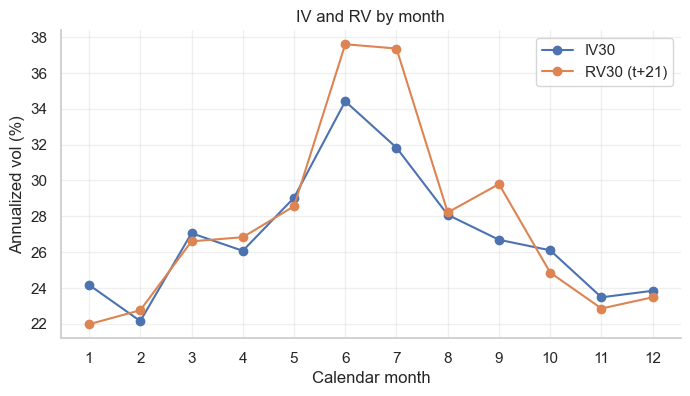

In [18]:
# Month-of-year averages for IV and future RV
sub = df[[C1_IV30, "Target_RV30"]].dropna().astype(float).copy()
sub["month"] = sub.index.month

monthly = sub.groupby("month")[[C1_IV30, "Target_RV30"]].mean()

print("Monthly average IV and Target_RV30:")
display(monthly)

plt.figure(figsize=(8, 4))
plt.plot(monthly.index, monthly[C1_IV30], marker="o", label="IV30")
plt.plot(monthly.index, monthly["Target_RV30"], marker="o", label="RV30 (t+21)")
plt.xticks(range(1, 13))
plt.xlabel("Calendar month")
plt.ylabel("Annualized vol (%)")
plt.title("IV and RV by month")
plt.legend()
plt.grid(alpha=0.3)
plt.savefig("figs/IVRVMonthly.png", dpi=300, bbox_inches='tight')
plt.show()


This figure highlights clear seasonality in corn volatility. Both implied volatility and future realized volatility peak in June–July, which corresponds to the pollination period. Importantly, during these months, future realized volatility is on average higher than implied volatility, suggesting systematic underpricing of volatility risk in summer. Outside this window, IV and RV move more closely together. This motivates the inclusion of calendar and seasonal features in the models.

Seasonal IV and Target_RV30 (mean / std):


C_1_Comdty_30DAY_IMPVOL_100.0%MNY_DF           Target_RV30  \
                                            mean       std        mean   
season                                                                   
harvest                                26.388245  8.958391   27.277348   
off-season                             24.840800  9.218402   24.340872   
planting                               27.580060  7.505694   27.709862   
pollination                            33.100244  7.622958   37.480267   

                        
                   std  
season                  
harvest      11.521933  
off-season    8.913319  
planting      8.419705  
pollination  15.844510

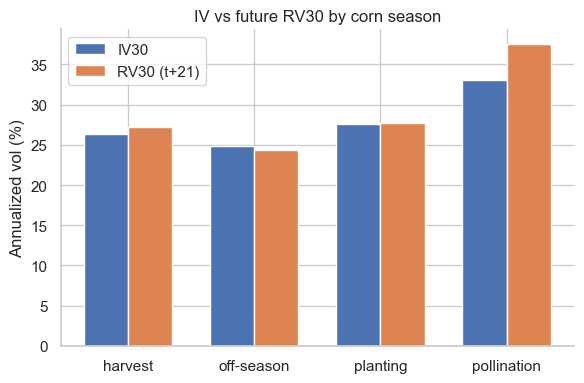

In [19]:
def corn_season_from_month(m):
    # Simple agronomic buckets for US corn
    if m in [4, 5]:
        return "planting"       # April–May
    if m in [6, 7]:
        return "pollination"    # June–July
    if m in [9, 10]:
        return "harvest"        # Sep–Oct
    return "off-season"

sub = df[[C1_IV30, "Target_RV30"]].dropna().astype(float).copy()
sub["season"] = sub.index.month.map(corn_season_from_month)

season_stats = sub.groupby("season")[[C1_IV30, "Target_RV30"]].agg(["mean", "std"])

print("Seasonal IV and Target_RV30 (mean / std):")
display(season_stats)

# Plot means only
season_means = sub.groupby("season")[[C1_IV30, "Target_RV30"]].mean()

plt.figure(figsize=(6, 4))
x = np.arange(len(season_means.index))
width = 0.35

plt.bar(x - width/2, season_means[C1_IV30], width, label="IV30")
plt.bar(x + width/2, season_means["Target_RV30"], width, label="RV30 (t+21)")

plt.xticks(x, season_means.index)
plt.ylabel("Annualized vol (%)")
plt.title("IV vs future RV30 by corn season")
plt.legend()
plt.tight_layout()
plt.savefig("figs/boxplot_season.png", dpi=300, bbox_inches='tight')
plt.show()


Grouping the data into agronomic seasons confirms the calendar results. Volatility is highest during the pollination period, where future realized volatility not only increases sharply but also exceeds implied volatility on average. This season also exhibits much higher dispersion, indicating greater uncertainty and tail risk. In contrast, planting, harvest, and off-season periods show lower and more balanced IV–RV dynamics. This supports using season-based features or regimes in the forecasting models.


Average IV / Target_RV30 by regime:


,C_1_Comdty_30DAY_IMPVOL_100.0%MNY_DF,Target_RV30
regime,,
COVID_2020,22.433316,21.600157
Drought_2012_13,26.813711,30.182506
GFC_2008_09,46.378701,48.897204
Ukraine_2022,30.024843,28.753138
normal,26.319948,26.829759


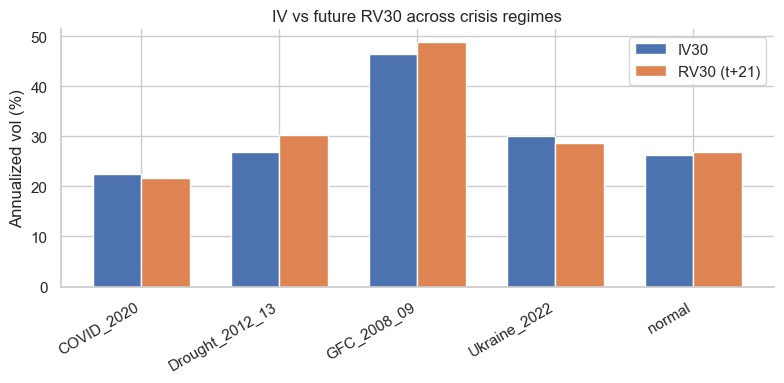

In [20]:
# Define a few crisis windows by hand
crisis_periods = [
    ("GFC_2008_09", "2008-09-01", "2009-03-31"),
    ("Drought_2012_13", "2012-06-01", "2013-12-31"),
    ("COVID_2020", "2020-02-01", "2020-12-31"),
    ("Ukraine_2022", "2022-02-01", "2022-12-31"),
]

sub = df[[C1_IV30, "Target_RV30"]].dropna().astype(float).copy()
sub["regime"] = "normal"

for label, start, end in crisis_periods:
    mask = (sub.index >= start) & (sub.index <= end)
    sub.loc[mask, "regime"] = label

regime_means = sub.groupby("regime")[[C1_IV30, "Target_RV30"]].mean()
print("Average IV / Target_RV30 by regime:")
display(regime_means)

plt.figure(figsize=(8, 4))
x = np.arange(len(regime_means.index))
width = 0.35

plt.bar(x - width/2, regime_means[C1_IV30], width, label="IV30")
plt.bar(x + width/2, regime_means["Target_RV30"], width, label="RV30 (t+21)")

plt.xticks(x, regime_means.index, rotation=30, ha="right")
plt.ylabel("Annualized vol (%)")
plt.title("IV vs future RV30 across crisis regimes")
plt.legend()
plt.tight_layout()
plt.savefig("figs/boxplot_crisis.png", dpi=300, bbox_inches='tight')
plt.show()


I also check a few well-known stress windows (chosen by hand) to see how IV compares to the realized volatility that follows. The main takeaway is that crisis periods coincide with higher volatility levels, and the IV–RV gap can behave differently than in normal times. I treat this as an illustrative sanity check rather than a formal regime definition.

## EDA – Key takeaways

**IV vs forward RV**
- IV30 and forward RV30 are strongly correlated (~0.7–0.75), but far from identical.
- The ex-post variance risk premium (IV − future RV) is close to balanced:
  - P(IV > RV) ≈ 51%, P(RV > IV) ≈ 49%.
- The median VRP is slightly positive, but the mean is negative, reflecting strong tail asymmetry.

**Tail risk dominates economics**
- When IV > RV, forecast errors are moderate and bounded.
- When RV > IV, errors are much larger and highly skewed, with extreme tail events.
- This asymmetry explains why naive short-variance strategies are fragile despite reasonable average forecasts.

**Seasonality matters**
- Both IV and forward RV peak during June–July (pollination period).
- In these months:
  - RV exceeds IV more often.
  - Conditional gaps (RV − IV) are substantially larger.
- The pattern is robust across years and not driven by a single outlier episode.

**Recurring tail regimes**
- June–July contains recurring “tail years” (notably 2013, 2021–2023) with:
  - Strongly negative VRP.
  - Frequent and severe RV overshoots relative to IV.
- Several of these years fall late in the sample, implying a more stressful test period.


# Model Training

In [21]:
# Backup the full dataset with USDA features for later
df_usda = df.copy()

# Identify and drop USDA columns from the active dataframe and drop them for later ablation study
usda_roots = ["HARVCORN", "GRINCORN", "CUSEENDS", "GCFPNPKI"]
drop_cols = [c for c in df.columns if any(r in c for r in usda_roots)]

df = df.drop(columns=drop_cols)

print(f"Dropped {len(drop_cols)} USDA columns from 'df'. Remaining shape: {df.shape}")

Dropped 23 USDA columns from 'df'. Remaining shape: (5222, 121)


In [22]:
# Target
y = df["Target_RV30"]

# Start from all columns except the target
feature_cols = [c for c in df.columns if c != "Target_RV30"]

# Features
X = df[feature_cols].copy()


print(df.shape, X.shape, y.shape)

(5222, 121) (5222, 120) (5222,)


In [23]:
X = X.sort_index()
y = y.loc[X.index]

n = len(X)
train_end = int(n * 0.7)
val_end   = int(n * 0.85)

X_train, y_train = X.iloc[:train_end], y.iloc[:train_end]
X_val,   y_val   = X.iloc[train_end:val_end], y.iloc[train_end:val_end]
X_test,  y_test  = X.iloc[val_end:], y.iloc[val_end:]

print("Train:", X_train.shape, 
      "Val:",   X_val.shape, 
      "Test:",  X_test.shape)

Train: (3655, 120) Val: (783, 120) Test: (784, 120)


In [24]:
def eval_forecast(y_true, y_pred, label="model"):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred)**0.5
    r2   = r2_score(y_true, y_pred)
    corr = np.corrcoef(y_true, y_pred)[0, 1]

    print(f"\n{label}")
    print(f"MAE:   {mae:.3f}")
    print(f"RMSE:  {rmse:.3f}")
    print(f"R^2:   {r2:.3f}")
    print(f"Corr:  {corr:.3f}")

---
### Naive IV benchmark

We use implied volatility as the direct forecast of future realized volatility:

$\widehat{\text{RV}}_{t+21} = \text{IV}_{t}^{30\text{D}}$

In [25]:
IV_COL = "C_1_Comdty_30DAY_IMPVOL_100.0%MNY_DF"

iv_train = df.loc[X_train.index, IV_COL].astype(float)
iv_val   = df.loc[X_val.index,   IV_COL].astype(float)
iv_test  = df.loc[X_test.index,  IV_COL].astype(float)

eval_forecast(y_val,  iv_val,  "Naive IV baseline (val)")
eval_forecast(y_test, iv_test, "Naive IV baseline (test)")


Naive IV baseline (val)
MAE:   6.103
RMSE:  8.258
R^2:   0.586
Corr:  0.777

Naive IV baseline (test)
MAE:   4.372
RMSE:  8.018
R^2:   0.462
Corr:  0.745


---
### Naive RV benchmark

We use current realized volatility as the forecast:

$\widehat{\text{RV}}_{t+21} = \text{RV}_{t}^{30\text{D}}$


In [26]:
RV_COL = "C_1_Comdty_VOLATILITY_30D"

rv_train = df.loc[X_train.index, RV_COL].astype(float)
rv_val   = df.loc[X_val.index,   RV_COL].astype(float)
rv_test  = df.loc[X_test.index,  RV_COL].astype(float)

eval_forecast(y_val,  rv_val,  "Naive RV baseline (val)")
eval_forecast(y_test, rv_test, "Naive RV baseline (test)")


Naive RV baseline (val)
MAE:   8.502
RMSE:  12.698
R^2:   0.021
Corr:  0.508

Naive RV baseline (test)
MAE:   5.548
RMSE:  10.873
R^2:   0.010
Corr:  0.506


---
### Model: HAR-RV (Modified Heterogeneous Autoregressive model)
We estimate a modified HAR model:
$\hat y_{t+h} = \beta_0 + \beta_{10} RV_t^{(10\text{D})} + \beta_{30} RV_t^{(30\text{D})} + \beta_{60} RV_t^{(60\text{D})}$

Unlike the standard daily/weekly/monthly HAR, we use volatilities over **10-day, 30-day, and 60-day horizons** to capture medium-to-long term persistence suitable for our monthly forecast target.

In [27]:
# HAR uses ONLY past Realized Volatility measures
# We select the daily, medium-term (10D), and long-term (60D) RV columns
har_cols = [
    "C_1_Comdty_VOLATILITY_30D", # Often acts as the "current" baseline
    "C_1_Comdty_VOLATILITY_10D", # Short term trend
    "C_1_Comdty_VOLATILITY_60D"  # Long term trend
]

X_har_train = X_train[har_cols].copy()
X_har_val   = X_val[har_cols].copy()
X_har_test  = X_test[har_cols].copy()

pipe_har = Pipeline([
    ("scaler", StandardScaler()),
    ("linreg", LinearRegression())
])

pipe_har.fit(X_har_train, y_train)

y_val_pred_har  = pipe_har.predict(X_har_val)
y_test_pred_har = pipe_har.predict(X_har_test)

eval_forecast(y_val,  y_val_pred_har,  "HAR-RV (RV only) (val)")
eval_forecast(y_test, y_test_pred_har, "HAR-RV (RV only) (test)")


HAR-RV (RV only) (val)
MAE:   6.885
RMSE:  9.808
R^2:   0.416
Corr:  0.648

HAR-RV (RV only) (test)
MAE:   5.050
RMSE:  8.512
R^2:   0.394
Corr:  0.645


---
### Linear regression with IV only

We fit a simple linear model that uses only today’s 30D implied volatility as a predictor of forward realized volatility:

$\widehat{\text{RV}}_{t+21}
= \beta_0 + \beta_1 \,\text{IV}_{t}^{30\text{D}}.$

This gives us a cleaner benchmark than the raw “IV = forecast” rule.


In [28]:
X_iv_train = iv_train.to_frame()
X_iv_val   = iv_val.to_frame()
X_iv_test  = iv_test.to_frame()

pipe_iv = Pipeline([
    ("scaler", StandardScaler()),
    ("linreg", LinearRegression())
])

pipe_iv.fit(X_iv_train, y_train)

y_val_pred_iv  = pipe_iv.predict(X_iv_val)
y_test_pred_iv = pipe_iv.predict(X_iv_test)

eval_forecast(y_val,  y_val_pred_iv,  "LinearReg(IV) (val)")
eval_forecast(y_test, y_test_pred_iv, "LinearReg(IV) (test)")


LinearReg(IV) (val)
MAE:   6.258
RMSE:  8.492
R^2:   0.562
Corr:  0.777

LinearReg(IV) (test)
MAE:   4.472
RMSE:  8.095
R^2:   0.451
Corr:  0.745


---
**Model: Linear regression on econ features**

We fit  $\hat y_t \;=\; \beta_0 \;+\; \sum_{j} \beta_j x_{t,j},$
where $x_{t,j}$ are the selected economic features (IV, RV lags, VRP, spreads).


We restrict features to an economically motivated subset: IV, historical RV (10D, 30D, 60D), VRP, C1–C2 spread, and simple seasonality / regime dummies (month, season, regimes) when available.


In [29]:
# Build an "econ" feature subset from X
econ_base_cols = [
    IV_COL,
    RV_COL,
    "C_1_Comdty_VOLATILITY_10D",
    "C_1_Comdty_VOLATILITY_60D",
    "C1_VRP30",
    "C1_C2_spread",
    "C1_C2_spread_pct",
]

# Add any seasonality / regime dummies
season_regime_cols = [
    c for c in X.columns
    if c.startswith("month_")
    or c.startswith("season_")
    or c.startswith("regime_")
]

econ_cols = [c for c in econ_base_cols + season_regime_cols if c in X.columns]

X_econ_train = X_train[econ_cols].copy()
X_econ_val   = X_val[econ_cols].copy()
X_econ_test  = X_test[econ_cols].copy()

pipe_econ = Pipeline([
    ("scaler", StandardScaler()),
    ("linreg", LinearRegression())
])

pipe_econ.fit(X_econ_train, y_train)

y_val_pred_econ  = pipe_econ.predict(X_econ_val)
y_test_pred_econ = pipe_econ.predict(X_econ_test)

eval_forecast(y_val,  y_val_pred_econ,  "LinearReg(econ) (val)")
eval_forecast(y_test, y_test_pred_econ, "LinearReg(econ) (test)")


LinearReg(econ) (val)
MAE:   5.189
RMSE:  6.678
R^2:   0.729
Corr:  0.885

LinearReg(econ) (test)
MAE:   3.867
RMSE:  5.831
R^2:   0.715
Corr:  0.847


---
**Model: Ridge regression (L2 penalty)**

We estimate $\hat y_t = \beta_0 + \sum_j \beta_j x_{t,j}$ by minimizing squared error with an L2 penalty.

We perform time-series cross-validation to select the regularization parameter $\alpha$ from a grid of **13 values between $10^{-3}$ and $10^3$** (0.001 to 1000).


In [30]:
alphas = np.logspace(-3, 3, 13)  # 0.001 to 1000
tscv = TimeSeriesSplit(n_splits=5)

pipe_ridge = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", RidgeCV(alphas=alphas, cv=tscv))
])

pipe_ridge.fit(X_train, y_train)

print("Chosen alpha (Ridge):", pipe_ridge.named_steps["ridge"].alpha_)

y_val_pred_ridge  = pipe_ridge.predict(X_val)
y_test_pred_ridge = pipe_ridge.predict(X_test)

eval_forecast(y_val,  y_val_pred_ridge,  "Ridge(all features) (val)")
eval_forecast(y_test, y_test_pred_ridge, "Ridge(all features) (test)")


Chosen alpha (Ridge): 1000.0

Ridge(all features) (val)
MAE:   5.182
RMSE:  6.802
R^2:   0.719
Corr:  0.850

Ridge(all features) (test)
MAE:   5.600
RMSE:  7.174
R^2:   0.569
Corr:  0.822


---
**Model: Lasso regression (L1 penalty)**

We estimate $\hat y_t = \beta_0 + \sum_j \beta_j x_{t,j}$ by minimizing squared error with an L1 penalty, which performs feature selection.

We perform time-series cross-validation to select $\alpha$ from a grid of **9 values between $10^{-3}$ and $10^1$** (0.001 to 10).

In [31]:
alphas = np.logspace(-3, 1, 9) 
tscv = TimeSeriesSplit(n_splits=5)

pipe_lasso = Pipeline([
    ("scaler", StandardScaler()),
    ("lasso", LassoCV(alphas=alphas, cv=tscv, max_iter=10000, n_jobs=-1))
])

pipe_lasso.fit(X_train, y_train)

print("Chosen alpha (Lasso):", pipe_lasso.named_steps["lasso"].alpha_)

y_val_pred_lasso  = pipe_lasso.predict(X_val)
y_test_pred_lasso = pipe_lasso.predict(X_test)

eval_forecast(y_val,  y_val_pred_lasso,  "Lasso(all features) (val)")
eval_forecast(y_test, y_test_pred_lasso, "Lasso(all features) (test)")


Chosen alpha (Lasso): 1.0

Lasso(all features) (val)
MAE:   5.041
RMSE:  6.357
R^2:   0.755
Corr:  0.880

Lasso(all features) (test)
MAE:   3.778
RMSE:  6.057
R^2:   0.693
Corr:  0.862


---
**Model: Random forest regressor**

We use an ensemble of regression trees to capture non-linearities and interactions.

**Hyperparameters:**
* Trees 500 estimators
* Regularization: `min_samples_leaf=5` (prevents overfitting by requiring at least 5 observations per leaf node).
* Depth: Unconstrained (`max_depth=None`).

In [32]:
rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    min_samples_leaf=5,
    random_state=0,
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_val_pred_rf  = rf.predict(X_val)
y_test_pred_rf = rf.predict(X_test)

eval_forecast(y_val,  y_val_pred_rf,  "RandomForest(all features) (val)")
eval_forecast(y_test, y_test_pred_rf, "RandomForest(all features) (test)")



RandomForest(all features) (val)
MAE:   7.305
RMSE:  11.381
R^2:   0.214
Corr:  0.736

RandomForest(all features) (test)
MAE:   5.595
RMSE:  8.532
R^2:   0.391
Corr:  0.662


---
**Model: Gradient boosting regressor**
We build a sequence of shallow trees, where each tree corrects the residuals of the previous ones.

**Hyperparameters:**
* Algorithm: Histogram-based Gradient Boosting (efficient for larger datasets).
* Structure: Shallow trees (`max_depth=4`) with `min_samples_leaf=20`.
* Learning: `learning_rate=0.05` with `max_iter=500` trees.


In [33]:
gbr = HistGradientBoostingRegressor(
    max_depth=4,
    learning_rate=0.05,
    max_iter=500,
    min_samples_leaf=20,
    random_state=0
)

gbr.fit(X_train, y_train)

y_val_pred_gbr  = gbr.predict(X_val)
y_test_pred_gbr = gbr.predict(X_test)

eval_forecast(y_val,  y_val_pred_gbr,  "HistGBR(all features) (val)")
eval_forecast(y_test, y_test_pred_gbr, "HistGBR(all features) (test)")



HistGBR(all features) (val)
MAE:   5.731
RMSE:  7.678
R^2:   0.642
Corr:  0.811

HistGBR(all features) (test)
MAE:   5.838
RMSE:  8.340
R^2:   0.418
Corr:  0.685


In [34]:
def calculate_metrics(y_true, y_pred):

    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    # Pearson Correlation (handle potential constant output edge cases)
    if len(np.unique(y_pred)) > 1:
        corr, _ = pearsonr(y_true, y_pred)
    else:
        corr = 0.0
        
    return mae, rmse, r2, corr

# Dictionary of models

model_preds = {
    "Naive IV Baseline":    (iv_val, iv_test),
    "Naive RV Baseline":    (rv_val, rv_test),
    "HAR-RV (Vol Only)":    (y_val_pred_har, y_test_pred_har),
    "LinearReg (IV Only)":  (y_val_pred_iv, y_test_pred_iv),
    "LinearReg (Econ)":     (y_val_pred_econ, y_test_pred_econ),
    "Ridge (All Feats)":    (y_val_pred_ridge, y_test_pred_ridge),
    "Lasso (All Feats)":    (y_val_pred_lasso, y_test_pred_lasso),
    "RandomForest":         (y_val_pred_rf, y_test_pred_rf),
    "HistGBR":              (y_val_pred_gbr, y_test_pred_gbr)
}

# Iterate and collect results
results_list = []

for model_name, (pred_val, pred_test) in model_preds.items():
    # Calculate Val Metrics
    val_mae, val_rmse, val_r2, val_corr = calculate_metrics(y_val, pred_val)
    
    # Calculate Test Metrics
    test_mae, test_rmse, test_r2, test_corr = calculate_metrics(y_test, pred_test)
    
    results_list.append({
        "Model": model_name,
        "Test MAE": test_mae,
        "Test RMSE": test_rmse,
        "Test R2": test_r2,
        "Test Corr": test_corr,
        "Val MAE": val_mae,       # Included to check for overfitting
        "Val R2": val_r2          # Included to check for overfitting
    })

# DataFrame
results_df = pd.DataFrame(results_list)

# Display sorted by Test RMSE (Lower is better)
results_df = results_df.set_index("Model")
results_df = results_df.sort_values(by="Test RMSE", ascending=True)

# Style the dataframe for Jupyter Notebooks
def style_table(df):
    return df.style.background_gradient(cmap='RdYlGn_r', subset=['Test MAE', 'Test RMSE']) \
                   .background_gradient(cmap='RdYlGn', subset=['Test R2', 'Test Corr']) \
                   .format("{:.4f}")

# Display
print("Benchmark Model Performance Sorted by RMSE")
display(style_table(results_df))

Benchmark Model Performance Sorted by RMSE


,Test MAE,Test RMSE,Test R2,Test Corr,Val MAE,Val R2
Model,,,,,,
LinearReg (Econ),3.8675,5.8313,0.7153,0.8468,5.1888,0.7293
Lasso (All Feats),3.7776,6.0575,0.6928,0.8620,5.0405,0.7548
Ridge (All Feats),5.6003,7.1741,0.5691,0.8216,5.1823,0.7192
Naive IV Baseline,4.3717,8.0177,0.4619,0.7447,6.1030,0.5861
LinearReg (IV Only),4.4717,8.0948,0.4515,0.7447,6.2582,0.5624
HistGBR,5.8378,8.3397,0.4178,0.6849,5.7312,0.6423
HAR-RV (Vol Only),5.0500,8.5116,0.3935,0.6447,6.8845,0.4161
RandomForest,5.5946,8.5325,0.3905,0.6618,7.3046,0.2139
Naive RV Baseline,5.5482,10.8735,0.0102,0.5059,8.5021,0.0215


I keep two benchmarks for the rest of the project:

- Linear regression (econ features): this is my best “simple + strong” model, and it uses only intuitive market/seasonality inputs.
- Naive IV baseline: this is the hard-to-beat reference, IV is observable in real time and acts as a clean benchmark.

I use the validation set to choose models and hyperparameters, and I reserve the test set exclusively for final evaluation.  
This is important because it prevents information leakage and optimistic bias, ensuring that reported test performance reflects true out-of-sample behavior rather than implicit tuning on future data.

---
# LSTM

Methodology Note: 

We standardized the split (70% Train, 15% Val, 15% Test) to ensure a mathematically valid comparison. Since the LSTM requires a 21-day lookback window, it cannot generate predictions for the first 21 days of the Test set. By fixing these indices now, we can later trim the Baseline models (Linear & IV) to match this gap, ensuring that all models are evaluated on the exact same timestamps.

In [35]:
# Train (70%), Val (15%), Test (15%)
n = len(df)
train_end = int(n * 0.70)
val_end   = int(n * 0.85)

df_train = df.iloc[:train_end].copy()
df_val   = df.iloc[train_end:val_end].copy()
df_test  = df.iloc[val_end:].copy()

print(f"Train: {df_train.shape} (0 -> {train_end})")
print(f"Val:   {df_val.shape} ({train_end} -> {val_end})")
print(f"Test:  {df_test.shape} ({val_end} -> {n})")

Train: (3655, 121) (0 -> 3655)
Val:   (783, 121) (3655 -> 4438)
Test:  (784, 121) (4438 -> 5222)


I retrained benchmark models on new dataset with 21 fewer observations on the test set (dropped for our LSTM initialization).
(so we compare apples to apples)

In [36]:
# Setup Data & Columns
econ_base = [IV_COL, RV_COL, "C_1_Comdty_VOLATILITY_10D", "C_1_Comdty_VOLATILITY_60D", 
             "C1_VRP30", "C1_C2_spread", "C1_C2_spread_pct"]
season_cols = [c for c in df.columns if any(x in c for x in ["month_", "season_", "regime_"])]
econ_cols = [c for c in econ_base + season_cols if c in df.columns]

X_econ_train = df_train[econ_cols].copy()
y_train      = df_train["Target_RV30"]
X_econ_test  = df_test[econ_cols].copy()

# STORE PREDICTIONS ONLY
baseline_preds = {}

# Naive IV (Market Baseline)
baseline_preds["Naive_IV"] = df_test[IV_COL].values

# Linear Regression (Econ Baseline)
pipe_econ = Pipeline([
    ("scaler", StandardScaler()),
    ("linreg", LinearRegression())
])
pipe_econ.fit(X_econ_train, y_train)
baseline_preds["Linear_Econ"] = pipe_econ.predict(X_econ_test)

# Store Actuals for safety
baseline_preds["Actuals"] = df_test["Target_RV30"].values

### Benchmark Model: LSTM (Baseline Deep Learning Model)

In [37]:
# Define target and features
target_col = "Target_RV30"
window = 21  # 21-day lookback

# All numeric features except the target
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != target_col]

print("LSTM numeric feature count:", len(numeric_cols))

# Split features and target 
X_train_full = df_train[numeric_cols].values
X_val_full   = df_val[numeric_cols].values
X_test_full  = df_test[numeric_cols].values

y_train_full = df_train[target_col].values
y_val_full   = df_val[target_col].values
y_test_full  = df_test[target_col].values  

# Scale features 
x_scaler = MinMaxScaler()
X_train_scaled = x_scaler.fit_transform(X_train_full)
X_val_scaled   = x_scaler.transform(X_val_full)
X_test_scaled  = x_scaler.transform(X_test_full)
y_scaler = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = y_scaler.fit_transform(y_train_full.reshape(-1, 1)).ravel()
y_val_scaled   = y_scaler.transform(y_val_full.reshape(-1, 1)).ravel()
y_test_scaled  = y_scaler.transform(y_test_full.reshape(-1, 1)).ravel()

# Helper to build 21-day sequences
def make_sequences(X_2d, y_1d, window):
    X_seq, y_seq = [], []
    for t in range(window, len(X_2d)):
        X_seq.append(X_2d[t-window:t, :])  # past `window` days
        y_seq.append(y_1d[t])              # predict current day
    return np.array(X_seq), np.array(y_seq)

# Build sequences using scaled targets
X_train_seq, y_train_seq_scaled = make_sequences(X_train_scaled, y_train_scaled, window)
X_val_seq,   y_val_seq_scaled   = make_sequences(X_val_scaled,   y_val_scaled,   window)
X_test_seq,  y_test_seq_scaled  = make_sequences(X_test_scaled,  y_test_scaled,  window)

print("Train seq shape:", X_train_seq.shape, y_train_seq_scaled.shape)
print("Val seq shape:  ", X_val_seq.shape,   y_val_seq_scaled.shape)
print("Test seq shape: ", X_test_seq.shape,  y_test_seq_scaled.shape)

set_global_seed(1234)

# Build Benchmark LSTM model
model_bench = Sequential([
    LSTM(64, input_shape=(window, X_train_seq.shape[-1])),
    Dropout(0.2),
    Dense(1)
])
model_bench.compile(optimizer="adam", loss="mse")

# Early stopping on validation loss
es = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

# Train Benchmark LSTM
history_bench = model_bench.fit(
    X_train_seq, y_train_seq_scaled,
    validation_data=(X_val_seq, y_val_seq_scaled),
    epochs=100,
    batch_size=32,
    callbacks=[es],
    verbose=1
)

# Predictions on test sequences (scaled -> original scale)
y_pred_bench_test_scaled = model_bench.predict(X_test_seq).flatten()
y_pred_bench_test = y_scaler.inverse_transform(
    y_pred_bench_test_scaled.reshape(-1, 1)
).ravel()

print("Benchmark LSTM test predictions shape:", y_pred_bench_test.shape)

# Unscaled test targets aligned with sequences (for RMSE & plots)
y_test_seq = y_scaler.inverse_transform(
    y_test_seq_scaled.reshape(-1, 1)
).ravel()


LSTM numeric feature count: 120
Train seq shape: (3634, 21, 120) (3634,)
Val seq shape:   (762, 21, 120) (762,)
Test seq shape:  (763, 21, 120) (763,)
Epoch 1/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0271 - val_loss: 0.0116
Epoch 2/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0092 - val_loss: 0.0098
Epoch 3/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0068 - val_loss: 0.0093
Epoch 4/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0057 - val_loss: 0.0095
Epoch 5/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0050 - val_loss: 0.0098
Epoch 6/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0045 - val_loss: 0.0097
Epoch 7/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0039 - val_loss: 0.0098
Epoch 8/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0037 - val_loss: 0.0102
Epoch 9/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0032 - val_loss: 0.0099
Epoch 10/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.00

In [38]:
# Store benchmark LSTM and benchmark performances

# Dictionary to store aligned predictions for plotting and comparison
model_preds = {}

# LSTM benchmark predictions and actuals (already aligned on test_day_21+)
model_preds["LSTM_Benchmark"] = y_pred_bench_test
model_preds["LSTM_Benchmark_Actuals"] = y_test_seq

# Dictionary to store RMSE scores
rmse_scores = {}
mae_scores  = {}
rmse_scores["LSTM_Benchmark"] = rmse(y_test_seq, y_pred_bench_test)
mae_scores["LSTM_Benchmark"] = mae(y_test_seq, y_pred_bench_test)


print("LSTM Benchmark RMSE:", rmse_scores["LSTM_Benchmark"])
print("LSTM Benchmark MAE:", mae_scores["LSTM_Benchmark"])

# Trim baselines and actuals to match the LSTM test horizon
actuals_trim = baseline_preds["Actuals"][window:]
naive_trim   = baseline_preds["Naive_IV"][window:]
econ_trim    = baseline_preds["Linear_Econ"][window:]

print("Trimmed shapes:",
      actuals_trim.shape, naive_trim.shape, econ_trim.shape)

# Add baseline predictions to the common dict for plotting
model_preds["Naive_IV"]    = naive_trim
model_preds["Linear_Econ"] = econ_trim

# For baselines, use the same trimmed actuals
rmse_scores["Naive_IV"]    = rmse(actuals_trim, naive_trim)
mae_scores["Naive_IV"]    = mae(actuals_trim, naive_trim)
rmse_scores["Linear_Econ"] = rmse(actuals_trim, econ_trim)
mae_scores["Linear_Econ"] = mae(actuals_trim, econ_trim)


print("Naive_IV RMSE (trimmed):   ", rmse_scores["Naive_IV"])
print("Naive_IV MAE (trimmed):   ", mae_scores["Naive_IV"])
print("Linear_Econ RMSE (trimmed):", rmse_scores["Linear_Econ"])
print("Linear_Econ MAE (trimmed):", mae_scores["Linear_Econ"])

LSTM Benchmark RMSE: 13.604506148849177
LSTM Benchmark MAE: 11.966960294531026
Trimmed shapes: (763,) (763,) (763,)
Naive_IV RMSE (trimmed):    8.109426550889564
Naive_IV MAE (trimmed):    4.423328964613368
Linear_Econ RMSE (trimmed): 5.893513682556388
Linear_Econ MAE (trimmed): 3.911211917659469


In this modeling phase, I first fixed two simple and interpretable benchmarks (naive IV and linear regression with economic features) and then trained a first LSTM as a neural network benchmark. I used a strict chronological train/validation/test split and applied all scaling using training data only.

For the LSTM, I constructed 21-day rolling input sequences to match the 30-day realized volatility forecasting horizon. Because the sequence construction removes the first 21 observations of each split, I explicitly trimmed the baseline predictions so that all models are evaluated on the exact same test dates. This ensures a fair, apples-to-apples comparison between the LSTM and the benchmark models.

At this stage, the benchmark LSTM serves as a reference point for further improvements rather than a final model.


### Optimized Model — Feature Engineering

### Stationarity Check & Feature Transformation:

We applied the Augmented Dickey-Fuller (ADF) test to all features to test for stationarity (p-value < 0.05).

Finding: Most raw price levels (_PX_) and moving averages (_MOV_AVG_) were non-stationary (contained trends). We decided to drop the raw non-stationary columns to prevent model instability. 

In [39]:
# ADF TEST FOR STATIONARITY

# Rebuild a DataFrame for the scaled train features
scaled_train_df = pd.DataFrame(
    X_train_scaled,
    columns=numeric_cols,
    index=df_train.index
)

non_stationary_feats = []
adf_pvalues = {}

for col in numeric_cols:
    series = scaled_train_df[col].dropna()
    try:
        result = adfuller(series, autolag="AIC")
        pval = result[1]
        adf_pvalues[col] = pval
        if pval > 0.05:  # fail to reject unit root at 5% level
            non_stationary_feats.append((col, pval))
    except Exception as e:
        print(f"ADF failed for {col}: {e}")

# Sort by p-value descending (most non-stationary first)
non_stationary_feats_sorted = sorted(non_stationary_feats, key=lambda x: x[1], reverse=True)

print(f"Number of features failing ADF at 5%: {len(non_stationary_feats_sorted)}")
for col, pval in non_stationary_feats_sorted:
    print(f"{col}: p-value = {pval:.4f}")


Number of features failing ADF at 5%: 43
DXY_Curncy_MOV_AVG_30D: p-value = 0.8041
DXY_Curncy_MOV_AVG_10D: p-value = 0.7310
DXY_Curncy_PX_HIGH: p-value = 0.6520
DXY_Curncy_PX_LAST: p-value = 0.6472
DXY_Curncy_PX_OPEN: p-value = 0.6389
DXY_Curncy_PX_LOW: p-value = 0.6240
USGG1M_Index_MOV_AVG_30D: p-value = 0.5394
USGG1M_Index_PX_HIGH: p-value = 0.5052
USGG1M_Index_MOV_AVG_10D: p-value = 0.5005
USGG1M_Index_PX_LAST: p-value = 0.4882
USGG1M_Index_PX_OPEN: p-value = 0.4842
USGG1M_Index_PX_LOW: p-value = 0.4706
USGG3M_Index_MOV_AVG_30D: p-value = 0.4537
USGG3M_Index_PX_HIGH: p-value = 0.4508
USGG3M_Index_PX_LOW: p-value = 0.4472
USGG3M_Index_MOV_AVG_10D: p-value = 0.4450
USGG3M_Index_PX_LAST: p-value = 0.4434
USGG3M_Index_PX_OPEN: p-value = 0.4385
USGG1M_Index_MOV_AVG_60D: p-value = 0.3126
CL1_Comdty_PX_OPEN: p-value = 0.3083
CL1_Comdty_PX_LAST: p-value = 0.3029
DXY_Curncy_MOV_AVG_60D: p-value = 0.2990
CL1_Comdty_MOV_AVG_30D: p-value = 0.2384
USGG3M_Index_MOV_AVG_60D: p-value = 0.2214
CL1_Co

In [40]:
# Identify columns to drop based on their names in numeric_cols
drop_flags = [("PX_" in c) or ("MOV_AVG_" in c) for c in numeric_cols]

cols_to_drop = [c for c, flag in zip(numeric_cols, drop_flags) if flag]
cols_to_keep = [c for c, flag in zip(numeric_cols, drop_flags) if not flag]

keep_indices = [i for i, flag in enumerate(drop_flags) if not flag]

print(f"Total numeric features before: {len(numeric_cols)}")
print(f"Number of PX_ / MOV_AVG_ features to drop: {len(cols_to_drop)}")
print("Dropped columns (preview):")
for c in cols_to_drop[:5]:
    print("  ", c)
if len(cols_to_drop) > 5:
    print("  ...")

# Apply the same column selection to the scaled matrices
X_train_scaled = X_train_scaled[:, keep_indices]
X_val_scaled   = X_val_scaled[:, keep_indices]
X_test_scaled  = X_test_scaled[:, keep_indices]

# Update numeric_cols to the cleaned list
numeric_cols = cols_to_keep

print("\nAfter dropping PX_ and MOV_AVG_ columns:")
print("  Remaining numeric features:", len(numeric_cols))
print("  X_train_scaled shape:", X_train_scaled.shape)
print("  X_val_scaled shape:  ", X_val_scaled.shape)
print("  X_test_scaled shape: ", X_test_scaled.shape)


Total numeric features before: 120
Number of PX_ / MOV_AVG_ features to drop: 53
Dropped columns (preview):
   C_1_Comdty_PX_LAST
   C_1_Comdty_PX_LOW
   C_1_Comdty_PX_HIGH
   C_1_Comdty_PX_OPEN
   C_1_Comdty_PX_VOLUME
  ...

After dropping PX_ and MOV_AVG_ columns:
  Remaining numeric features: 67
  X_train_scaled shape: (3655, 67)
  X_val_scaled shape:   (783, 67)
  X_test_scaled shape:  (784, 67)


ADF tests were run on both raw and scaled versions of the features. The results were consistent and primarily identified price levels and moving averages as non-stationary. Based on this diagnostic and economic considerations, all price-level and moving-average features were removed.

Correlation matrix shape: (3655, 67)

Number of pairs with |corr| >= 0.98: 1
C_1_Comdty_30DAY_IMPVOL_100.0%MNY_DF  --  C_2_Comdty_30DAY_IMPVOL_100.0%MNY_DF   corr = 1.000


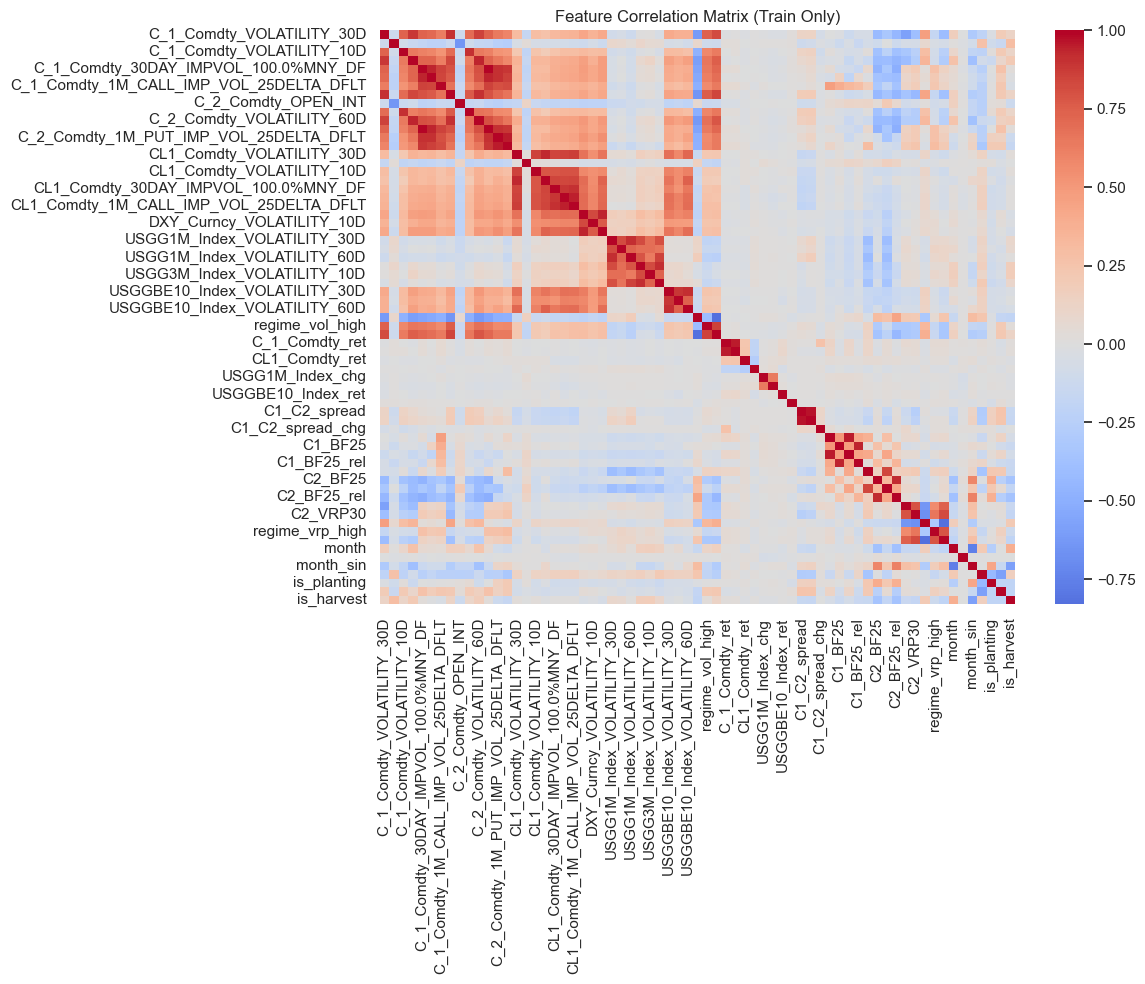

In [41]:
# Build dataframe from scaled X_train
Xcorr_df = pd.DataFrame(
    X_train_scaled,
    columns=numeric_cols,
    index=df_train.index
)

print("Correlation matrix shape:", Xcorr_df.shape)

# Correlation matrix 
corr_matrix = Xcorr_df.corr()

# Find highly correlated pairs
corr_threshold = 0.98  

high_corr_pairs = []

cols = corr_matrix.columns
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) >= corr_threshold:
            high_corr_pairs.append((
                cols[i],
                cols[j],
                corr_val
            ))

# Sort by absolute correlation descending
high_corr_pairs = sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True)

print(f"\nNumber of pairs with |corr| >= {corr_threshold}: {len(high_corr_pairs)}")
for a, b, c in high_corr_pairs[:40]:
    print(f"{a:35s}  --  {b:35s}   corr = {c:.3f}")
if len(high_corr_pairs) > 40:
    print("...")

# Heatmap
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0)
plt.title("Feature Correlation Matrix (Train Only)")
plt.tight_layout()
plt.show()


In [42]:
# Fit Random Forest on cleaned, scaled train features
rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    min_samples_leaf=5,
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train_scaled, y_train_full)

# Permutation importance on TRAIN (only uses X_train_scaled, y_train_full)
perm_result = permutation_importance(
    rf,
    X_train_scaled,
    y_train_full,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# Build a sorted importance Series
rf_importances = pd.Series(
    perm_result.importances_mean,
    index=numeric_cols
).sort_values(ascending=False)

print("Top 20 features by RF permutation importance:")
print(rf_importances.head(20))

Top 20 features by RF permutation importance:
C_2_Comdty_VOLATILITY_60D                  0.276635
C_1_Comdty_30DAY_IMPVOL_100.0%MNY_DF       0.178513
C_2_Comdty_30DAY_IMPVOL_100.0%MNY_DF       0.149315
CL1_Comdty_VOLATILITY_30D                  0.087576
C_1_Comdty_VOLATILITY_10D                  0.049990
C1_C2_spread                               0.041597
USGG1M_Index_VOLATILITY_60D                0.035073
C_2_Comdty_1M_CALL_IMP_VOL_25DELTA_DFLT    0.017305
C_2_Comdty_VOLATILITY_10D                  0.016720
month_cos                                  0.016081
USGG1M_Index_VOLATILITY_30D                0.010933
C1_C2_spread_pct                           0.009853
C_2_Comdty_1M_PUT_IMP_VOL_25DELTA_DFLT     0.009474
CL1_Comdty_VOLATILITY_60D                  0.008322
DXY_Curncy_VOLATILITY_30D                  0.007419
USGGBE10_Index_VOLATILITY_60D              0.006708
USGG3M_Index_VOLATILITY_60D                0.006419
C_2_Comdty_OPEN_INT                        0.005814
DXY_Curncy_VOLATIL

I rank features using a training-only importance heuristic.

I fit a Random Forest on the training set (after dropping price levels and moving averages) and compute permutation importance on the same training data. For each feature, I randomly shuffle its values and measure how much prediction accuracy deteriorates. Features that cause the largest drop are treated as more informative.

This ranking is used purely as a screening tool to reduce dimensionality before training the LSTM. It is not interpreted as causal or out-of-sample importance. The final choice of features and model quality is still assessed using validation performance, ensuring no information from the validation or test sets is used at this stage.

In [43]:
# Rebuild correlation matrix on train (for the current numeric_cols / X_train_scaled)
Xcorr_df = pd.DataFrame(
    X_train_scaled,
    columns=numeric_cols,
    index=df_train.index
)
corr_matrix = Xcorr_df.corr()

# Walk RF ranking from most to least important
corr_threshold = 0.98  
selected_features = []
for feat in rf_importances.index:
    if not selected_features:
        selected_features.append(feat)
        continue
    
    # Max absolute correlation with already selected features
    max_corr = corr_matrix.loc[feat, selected_features].abs().max()
    
    if max_corr < corr_threshold:
        selected_features.append(feat)

print(f"Total features before duplicate-killer: {len(numeric_cols)}")
print(f"Features kept after duplicate-killer:  {len(selected_features)}")

print("\nSelected features (in order of RF importance, duplicates removed):")
for f in selected_features[:10]:
    print("  ", f)
if len(selected_features) > 10:
    print("  ...")

Total features before duplicate-killer: 67
Features kept after duplicate-killer:  66

Selected features (in order of RF importance, duplicates removed):
   C_2_Comdty_VOLATILITY_60D
   C_1_Comdty_30DAY_IMPVOL_100.0%MNY_DF
   CL1_Comdty_VOLATILITY_30D
   C_1_Comdty_VOLATILITY_10D
   C1_C2_spread
   USGG1M_Index_VOLATILITY_60D
   C_2_Comdty_1M_CALL_IMP_VOL_25DELTA_DFLT
   C_2_Comdty_VOLATILITY_10D
   month_cos
   USGG1M_Index_VOLATILITY_30D
  ...


(NOTE: This step removed only one feature)

In [44]:
# Ks we want to test
K_candidates = [10, 20, 30, 40, 50, 60, 70]
K_candidates = [K for K in K_candidates if K <= len(selected_features)]


R = 5  # number of runs per K
results_K = {}  # K -> list of MAEs

for K in K_candidates:
    print(f"\nEvaluating K = {K} features over {R} runs")
    topK_feats = selected_features[:K]
    feat_indices = [numeric_cols.index(f) for f in topK_feats]
    
    # Subset X_train_scaled and X_val_scaled once for this K
    X_train_K = X_train_scaled[:, feat_indices]
    X_val_K   = X_val_scaled[:, feat_indices]
    
    # Build sequences for train and val using *scaled* y (once per K)
    X_train_seq_K, y_train_seq_scaled_K = make_sequences(X_train_K, y_train_scaled, window)
    X_val_seq_K,   y_val_seq_scaled_K   = make_sequences(X_val_K,   y_val_scaled,   window)
    
    print(f"  Train seq: {X_train_seq_K.shape}, Val seq: {X_val_seq_K.shape}")
    
    mae_runs = []
    
    for r in range(R):
        seed = 1234 + 100*K + r  # deterministic but different per (K, run)
        set_global_seed(seed)
        
        # Simple LSTM architecture for K selection
        model_K = Sequential([
            LSTM(32, input_shape=(window, X_train_seq_K.shape[-1])),
            Dropout(0.3),
            Dense(1)
        ])
        model_K.compile(optimizer="adam", loss="mse")
        
        es_K = EarlyStopping(
            monitor="val_loss",
            patience=10,
            restore_best_weights=True
        )
        
        history_K = model_K.fit(
            X_train_seq_K, y_train_seq_scaled_K,
            validation_data=(X_val_seq_K, y_val_seq_scaled_K),
            epochs=100,
            batch_size=32,
            callbacks=[es_K],
            verbose=0
        )
        
        # Predictions on validation set
        y_val_pred_scaled = model_K.predict(X_val_seq_K, verbose=0).flatten()
        
        # Inverse-transform to original RV scale for MAE
        y_val_seq_unscaled = y_scaler.inverse_transform(
            y_val_seq_scaled_K.reshape(-1, 1)
        ).ravel()
        y_val_pred_unscaled = y_scaler.inverse_transform(
            y_val_pred_scaled.reshape(-1, 1)
        ).ravel()
        
        val_mae = mae(y_val_seq_unscaled, y_val_pred_unscaled)
        mae_runs.append(val_mae)
        print(f"    Run {r+1} MAE: {val_mae:.4f}")
    
    results_K[K] = mae_runs

# Summary: mean ± std per K, and best K by mean MAE
print("\nRobust K selection (Validation MAE, mean ± std over runs)")
mean_std_by_K = {}
for K in sorted(results_K):
    mae_list = results_K[K]
    mean_mae = np.mean(mae_list)
    std_mae  = np.std(mae_list)
    mean_std_by_K[K] = (mean_mae, std_mae)
    print(f"K={K}: mean MAE={mean_mae:.4f}, std={std_mae:.4f}, runs={mae_list}")

best_K = min(mean_std_by_K, key=lambda k: mean_std_by_K[k][0])
best_mean, best_std = mean_std_by_K[best_K]
print(f"\nBest K by mean validation MAE: K={best_K}, mean MAE={best_mean:.4f}, std={best_std:.4f}")



Evaluating K = 10 features over 5 runs
  Train seq: (3634, 21, 10), Val seq: (762, 21, 10)
    Run 1 MAE: 5.8622
    Run 2 MAE: 5.6167
    Run 3 MAE: 5.1328
    Run 4 MAE: 5.5707
    Run 5 MAE: 6.0494

Evaluating K = 20 features over 5 runs
  Train seq: (3634, 21, 20), Val seq: (762, 21, 20)
    Run 1 MAE: 5.7055
    Run 2 MAE: 6.0923
    Run 3 MAE: 5.5906
    Run 4 MAE: 5.6787
    Run 5 MAE: 5.3984

Evaluating K = 30 features over 5 runs
  Train seq: (3634, 21, 30), Val seq: (762, 21, 30)
    Run 1 MAE: 5.6163
    Run 2 MAE: 5.4570
    Run 3 MAE: 5.7199
    Run 4 MAE: 5.2687
    Run 5 MAE: 5.7530

Evaluating K = 40 features over 5 runs
  Train seq: (3634, 21, 40), Val seq: (762, 21, 40)
    Run 1 MAE: 5.2296
    Run 2 MAE: 5.7972
    Run 3 MAE: 5.6139
    Run 4 MAE: 5.6317
    Run 5 MAE: 5.7988

Evaluating K = 50 features over 5 runs
  Train seq: (3634, 21, 50), Val seq: (762, 21, 50)
    Run 1 MAE: 5.9805
    Run 2 MAE: 5.9301
    Run 3 MAE: 6.7475
    Run 4 MAE: 5.9284
    Run 5 MA

I select K (the number of feature used) by minimizing mean validation MAE over multiple seeded runs, and I fix K=30 for all subsequent LSTM experiments.

In [45]:
# Lock K* and feature list
best_K = 30
top_feats = selected_features[:best_K]

# Map to indices in numeric_cols
feat_indices_30 = [numeric_cols.index(f) for f in top_feats]

# Subset the scaled X matrices
X_train_30 = X_train_scaled[:, feat_indices_30]
X_val_30   = X_val_scaled[:, feat_indices_30]
X_test_30  = X_test_scaled[:, feat_indices_30]

print("Top-30 features:", top_feats)
print("X_train_30 shape:", X_train_30.shape)
print("X_val_30 shape:  ", X_val_30.shape)
print("X_test_30 shape: ", X_test_30.shape)

# Build sequences once for search (using scaled y)
X_train_seq_30, y_train_seq_scaled_30 = make_sequences(X_train_30, y_train_scaled, window)
X_val_seq_30,   y_val_seq_scaled_30   = make_sequences(X_val_30,   y_val_scaled,   window)
X_test_seq_30,  y_test_seq_scaled_30  = make_sequences(X_test_30,  y_test_scaled,  window)

print("Train seq 30 shape:", X_train_seq_30.shape, y_train_seq_scaled_30.shape)
print("Val seq 30 shape:  ", X_val_seq_30.shape,   y_val_seq_scaled_30.shape)
print("Test seq 30 shape: ", X_test_seq_30.shape,  y_test_seq_scaled_30.shape)

Top-30 features: ['C_2_Comdty_VOLATILITY_60D', 'C_1_Comdty_30DAY_IMPVOL_100.0%MNY_DF', 'CL1_Comdty_VOLATILITY_30D', 'C_1_Comdty_VOLATILITY_10D', 'C1_C2_spread', 'USGG1M_Index_VOLATILITY_60D', 'C_2_Comdty_1M_CALL_IMP_VOL_25DELTA_DFLT', 'C_2_Comdty_VOLATILITY_10D', 'month_cos', 'USGG1M_Index_VOLATILITY_30D', 'C1_C2_spread_pct', 'C_2_Comdty_1M_PUT_IMP_VOL_25DELTA_DFLT', 'CL1_Comdty_VOLATILITY_60D', 'DXY_Curncy_VOLATILITY_30D', 'USGGBE10_Index_VOLATILITY_60D', 'USGG3M_Index_VOLATILITY_60D', 'C_2_Comdty_OPEN_INT', 'DXY_Curncy_VOLATILITY_60D', 'USGGBE10_Index_VOLATILITY_30D', 'C_1_Comdty_OPEN_INT', 'USGG3M_Index_VOLATILITY_30D', 'C2_RR25', 'month_sin', 'C_1_Comdty_VOLATILITY_30D', 'C_2_Comdty_VOLATILITY_30D', 'USGG3M_Index_VOLATILITY_10D', 'DXY_Curncy_VOLATILITY_10D', 'C_1_Comdty_1M_CALL_IMP_VOL_25DELTA_DFLT', 'C_1_Comdty_VOLATILITY_60D', 'USGGBE10_Index_VOLATILITY_10D']
X_train_30 shape: (3655, 30)
X_val_30 shape:   (783, 30)
X_test_30 shape:  (784, 30)
Train seq 30 shape: (3634, 21, 30) (3

In [46]:
param_grid = []
for units in [16, 32, 64]:
    for dropout in [0.2, 0.5]:
        param_grid.append((units, dropout))

opt_results = []

for units, dropout in param_grid:
    print(f"\nOptimized config: units={units}, dropout={dropout}")
    
    # Seed for reproducibility (different per config)
    seed = 2025 + units * 10 + int(dropout * 100)
    set_global_seed(seed)
    
    # Build model
    model = Sequential([
        LSTM(units, input_shape=(window, X_train_seq_30.shape[-1])),
        Dropout(dropout),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    
    es = EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True
    )
    
    history = model.fit(
        X_train_seq_30, y_train_seq_scaled_30,
        validation_data=(X_val_seq_30, y_val_seq_scaled_30),
        epochs=100,
        batch_size=32,
        callbacks=[es],
        verbose=0
    )
    
    # Predict on validation
    y_val_pred_scaled = model.predict(X_val_seq_30, verbose=0).flatten()
    
    # Back to original RV scale
    y_val_true_unscaled = y_scaler.inverse_transform(
        y_val_seq_scaled_30.reshape(-1, 1)
    ).ravel()
    y_val_pred_unscaled = y_scaler.inverse_transform(
        y_val_pred_scaled.reshape(-1, 1)
    ).ravel()
    
    val_mae = mae(y_val_true_unscaled, y_val_pred_unscaled)
    opt_results.append({
        "units": units,
        "dropout": dropout,
        "val_mae": val_mae
    })
    print(f"  Validation MAE: {val_mae:.4f}")

# Summary and best config
print("\n Optimized grid search results (Validation MAE)")
for res in opt_results:
    print(f"units={res['units']}, dropout={res['dropout']}: MAE={res['val_mae']:.4f}")

best_cfg = min(opt_results, key=lambda d: d["val_mae"])
print(f"\nBest Optimized config: units={best_cfg['units']}, dropout={best_cfg['dropout']}, "
      f"val MAE={best_cfg['val_mae']:.4f}")


Optimized config: units=16, dropout=0.2
  Validation MAE: 5.6253

Optimized config: units=16, dropout=0.5
  Validation MAE: 5.0651

Optimized config: units=32, dropout=0.2
  Validation MAE: 5.5373

Optimized config: units=32, dropout=0.5
  Validation MAE: 5.4397

Optimized config: units=64, dropout=0.2
  Validation MAE: 5.3111

Optimized config: units=64, dropout=0.5
  Validation MAE: 5.7450

 Optimized grid search results (Validation MAE)
units=16, dropout=0.2: MAE=5.6253
units=16, dropout=0.5: MAE=5.0651
units=32, dropout=0.2: MAE=5.5373
units=32, dropout=0.5: MAE=5.4397
units=64, dropout=0.2: MAE=5.3111
units=64, dropout=0.5: MAE=5.7450

Best Optimized config: units=16, dropout=0.5, val MAE=5.0651



Training Optimized LSTM with top-10 features
  Train+Val seq shape: (4417, 21, 10)  Test seq shape: (763, 21, 10)
  Lengths (actuals_trim, y_test_seq_unscaled_K, y_pred_test_K): 763 763 763
  Allclose(y_test_seq_unscaled_K, actuals_trim)? True
  Test RMSE (K=10): 7.2632
  Test MAE  (K=10): 4.7820

Training Optimized LSTM with top-30 features
  Train+Val seq shape: (4417, 21, 30)  Test seq shape: (763, 21, 30)
  Lengths (actuals_trim, y_test_seq_unscaled_K, y_pred_test_K): 763 763 763
  Allclose(y_test_seq_unscaled_K, actuals_trim)? True
  Test RMSE (K=30): 6.9085
  Test MAE  (K=30): 4.5404

Test RMSE & MAE comparison (sorted by MAE):
                Model  Test_RMSE   Test_MAE
1         Linear_Econ   5.893514   3.911212
0            Naive_IV   8.109427   4.423329
4  LSTM_Optimized_K30   6.908490   4.540358
3  LSTM_Optimized_K10   7.263212   4.782007
2      LSTM_Benchmark  13.604506  11.966960


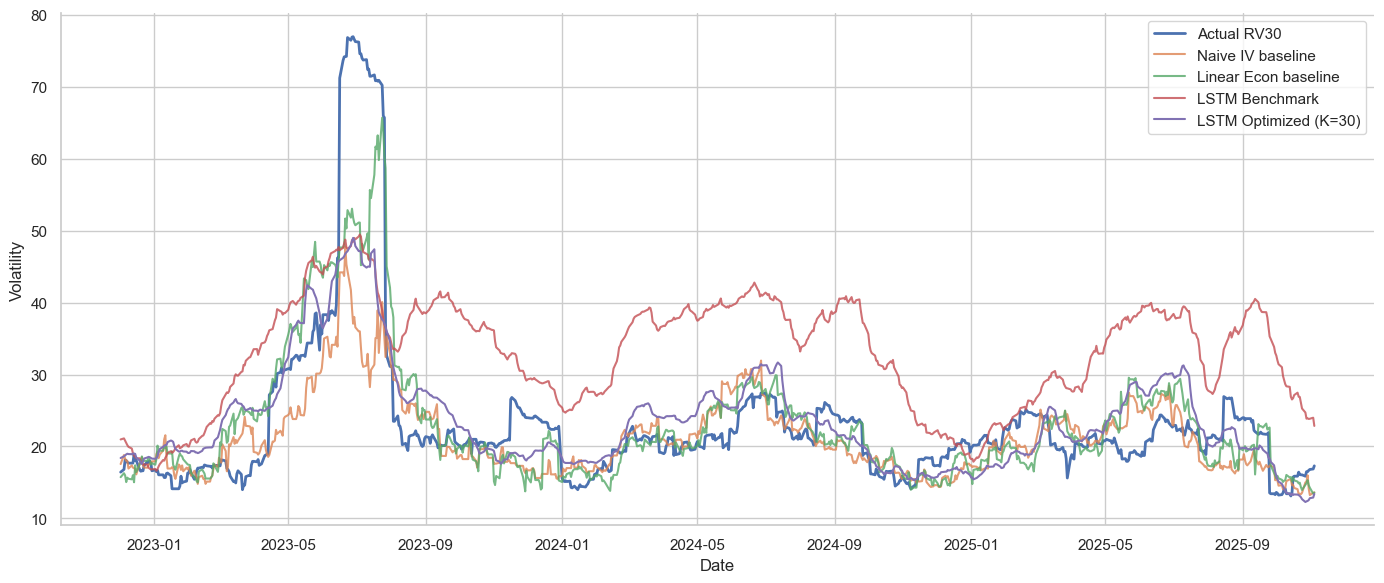

In [49]:
# Optimized LSTM, same architecture for K=10 and K=30
opt_units = 16
opt_dropout = 0.5
Ks_to_eval = [10, 30]

actuals_trim = baseline_preds["Actuals"][window:]  # aligned target on test set
test_dates = df_test.index
dates_aligned = test_dates[window:]

for K in Ks_to_eval:
    print(f"\nTraining Optimized LSTM with top-{K} features")
    
    # Select top-K features
    top_feats = selected_features[:K]
    feat_indices = [numeric_cols.index(f) for f in top_feats]
    
    # Subset scaled X
    X_train_K = X_train_scaled[:, feat_indices]
    X_val_K   = X_val_scaled[:, feat_indices]
    X_test_K  = X_test_scaled[:, feat_indices]
    
    # Merge Train + Val for final training
    X_trainval_K = np.vstack([X_train_K, X_val_K])
    y_trainval_scaled_K = np.concatenate([y_train_scaled, y_val_scaled])
    
    # Build sequences for Train+Val and Test
    X_trainval_seq_K, y_trainval_seq_scaled_K = make_sequences(
        X_trainval_K, y_trainval_scaled_K, window
    )
    X_test_seq_K, y_test_seq_scaled_K = make_sequences(
        X_test_K, y_test_scaled, window
    )
    
    print("  Train+Val seq shape:", X_trainval_seq_K.shape,
          " Test seq shape:", X_test_seq_K.shape)
    
    # Optimized model, fixed hyperparams
    set_global_seed(2026 + K)  # different but reproducible per K
    
    model_opt_K = Sequential([
        LSTM(opt_units, input_shape=(window, X_trainval_seq_K.shape[-1])),
        Dropout(opt_dropout),
        Dense(1)
    ])
    model_opt_K.compile(optimizer="adam", loss="mse")
    
    es_opt = EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True
    )
    
    # Small hold-out inside train+val for early stopping
    split_idx = int(0.9 * len(X_trainval_seq_K))
    X_tr_opt, X_val_opt = X_trainval_seq_K[:split_idx], X_trainval_seq_K[split_idx:]
    y_tr_opt, y_val_opt = y_trainval_seq_scaled_K[:split_idx], y_trainval_seq_scaled_K[split_idx:]
    
    history_opt_K = model_opt_K.fit(
        X_tr_opt, y_tr_opt,
        validation_data=(X_val_opt, y_val_opt),
        epochs=100,
        batch_size=32,
        callbacks=[es_opt],
        verbose=0
    )
    
    # Predictions on test, back to original scale
    y_pred_test_scaled_K = model_opt_K.predict(X_test_seq_K, verbose=0).flatten()
    y_pred_test_K = y_scaler.inverse_transform(
        y_pred_test_scaled_K.reshape(-1, 1)
    ).ravel()
    
    y_test_seq_unscaled_K = y_scaler.inverse_transform(
        y_test_seq_scaled_K.reshape(-1, 1)
    ).ravel()
    
    # Sanity check alignment
    print(
        "  Lengths (actuals_trim, y_test_seq_unscaled_K, y_pred_test_K):",
        len(actuals_trim), len(y_test_seq_unscaled_K), len(y_pred_test_K)
    )
    print("  Allclose(y_test_seq_unscaled_K, actuals_trim)?",
          np.allclose(y_test_seq_unscaled_K, actuals_trim))
    
    # Store metrics and predictions
    key = f"LSTM_Optimized_K{K}"
    model_preds[key] = y_pred_test_K
    rmse_scores[key] = rmse(actuals_trim, y_pred_test_K)
    mae_scores[key]  = mae(actuals_trim, y_pred_test_K)
    print(f"  Test RMSE (K={K}): {rmse_scores[key]:.4f}")
    print(f"  Test MAE  (K={K}): {mae_scores[key]:.4f}")


# Comparison table: Naive, Linear, Benchmark, Optimized K=10, Optimized K=30
results_df = pd.DataFrame({
    "Model": [
        "Naive_IV",
        "Linear_Econ",
        "LSTM_Benchmark",
        "LSTM_Optimized_K10",
        "LSTM_Optimized_K30"
    ],
    "Test_RMSE": [
        rmse_scores["Naive_IV"],
        rmse_scores["Linear_Econ"],
        rmse_scores["LSTM_Benchmark"],
        rmse_scores["LSTM_Optimized_K10"],
        rmse_scores["LSTM_Optimized_K30"]
    ],
    "Test_MAE": [
        mae_scores["Naive_IV"],
        mae_scores["Linear_Econ"],
        mae_scores["LSTM_Benchmark"],
        mae_scores["LSTM_Optimized_K10"],
        mae_scores["LSTM_Optimized_K30"]
    ]
})

print("\nTest RMSE & MAE comparison (sorted by MAE):")
print(results_df.sort_values("Test_MAE"))


# Plot: Actual vs all models on aligned test horizon
plt.figure(figsize=(14, 6))
plt.plot(dates_aligned, actuals_trim, label="Actual RV30", linewidth=2)
plt.plot(dates_aligned, model_preds["Naive_IV"], label="Naive IV baseline", alpha=0.8)
plt.plot(dates_aligned, model_preds["Linear_Econ"], label="Linear Econ baseline", alpha=0.8)
plt.plot(dates_aligned, model_preds["LSTM_Benchmark"], label="LSTM Benchmark", alpha=0.8)
plt.plot(dates_aligned, model_preds["LSTM_Optimized_K30"], label="LSTM Optimized (K=30)", alpha=1)
# plt.title("Test Set Volatility Forecasts vs Actual RV30\nAligned after 21-day LSTM lookback")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.tight_layout()
plt.savefig("figs/forecastsimple.png", dpi=300, bbox_inches='tight')
plt.show()


### Optimized LSTM — Results, Interpretation, and Limitations

**What we did (rigorous setup):**
- Trained an LSTM with a fixed 21-day lookback to forecast `Target_RV30`.
- Kept the evaluation clean:
  - Feature relevance ranking (RF permutation importance) was computed on train only.
  - `K` (top-K features) and LSTM hyperparameters were selected using the validation set only.
  - The test set was used only once, at the end, for final out-of-sample reporting.
- Ensured correct time alignment for LSTM forecasts by trimming the first 21 test days and verifying alignment with an explicit sanity check (`allclose`).

# Ablation  Study (HYBRID Regression-LSTM Model)


[HYBRID] Using top-30 features for residual-LSTM:
['C_2_Comdty_VOLATILITY_60D', 'C_1_Comdty_30DAY_IMPVOL_100.0%MNY_DF', 'CL1_Comdty_VOLATILITY_30D', 'C_1_Comdty_VOLATILITY_10D', 'C1_C2_spread', 'USGG1M_Index_VOLATILITY_60D', 'C_2_Comdty_1M_CALL_IMP_VOL_25DELTA_DFLT', 'C_2_Comdty_VOLATILITY_10D', 'month_cos', 'USGG1M_Index_VOLATILITY_30D', 'C1_C2_spread_pct', 'C_2_Comdty_1M_PUT_IMP_VOL_25DELTA_DFLT', 'CL1_Comdty_VOLATILITY_60D', 'DXY_Curncy_VOLATILITY_30D', 'USGGBE10_Index_VOLATILITY_60D', 'USGG3M_Index_VOLATILITY_60D', 'C_2_Comdty_OPEN_INT', 'DXY_Curncy_VOLATILITY_60D', 'USGGBE10_Index_VOLATILITY_30D', 'C_1_Comdty_OPEN_INT', 'USGG3M_Index_VOLATILITY_30D', 'C2_RR25', 'month_sin', 'C_1_Comdty_VOLATILITY_30D', 'C_2_Comdty_VOLATILITY_30D', 'USGG3M_Index_VOLATILITY_10D', 'DXY_Curncy_VOLATILITY_10D', 'C_1_Comdty_1M_CALL_IMP_VOL_25DELTA_DFLT', 'C_1_Comdty_VOLATILITY_60D', 'USGGBE10_Index_VOLATILITY_10D']
[HYBRID] Residual-LSTM seq shapes:
  Train: (3634, 21, 30) (3634,)
  Val:   (762, 21, 30

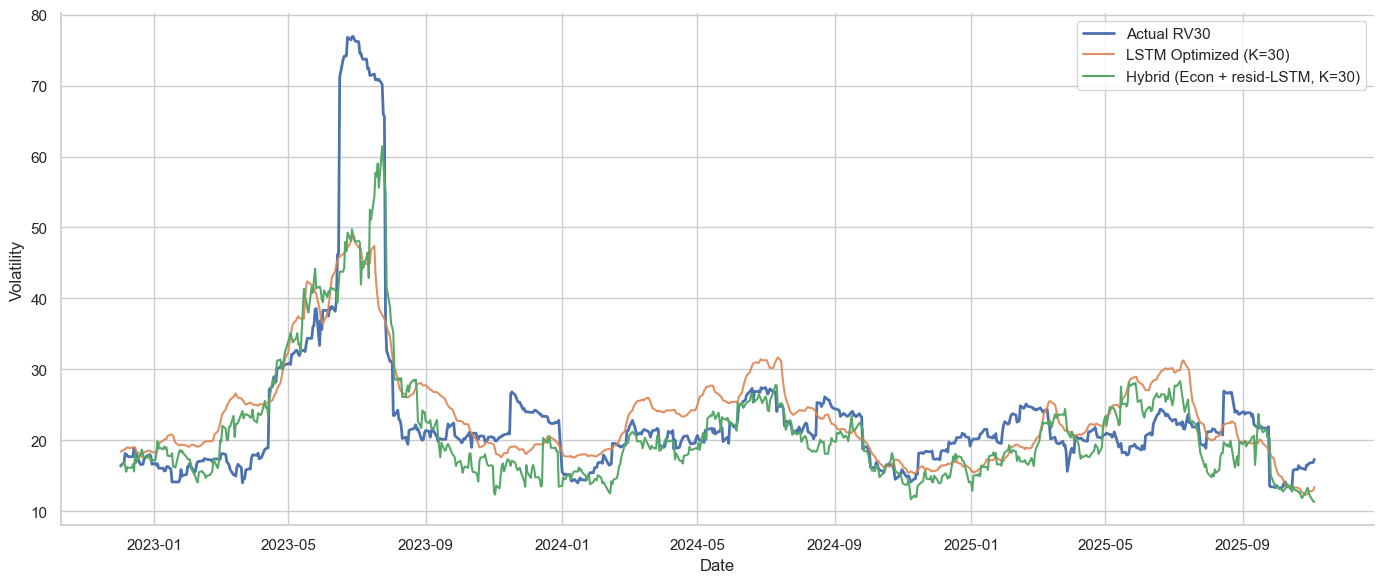

In [50]:
# HYBRID: Linear_Econ + LSTM on residuals

# Safety checks
assert "Linear_Econ" in baseline_preds, "baseline_preds['Linear_Econ'] missing"
assert "Actuals" in baseline_preds, "baseline_preds['Actuals'] missing"
assert len(baseline_preds["Linear_Econ"]) == len(df_test), "Linear_Econ length mismatch vs df_test"
assert len(baseline_preds["Actuals"]) == len(df_test), "Actuals length mismatch vs df_test"

# Build residual targets on train/val/test (aligned in raw daily space)
econ_pred_train = pipe_econ.predict(df_train[econ_cols])
econ_pred_val   = pipe_econ.predict(df_val[econ_cols])
econ_pred_test  = baseline_preds["Linear_Econ"]  # already computed

resid_train = df_train[target_col].values - econ_pred_train
resid_val   = df_val[target_col].values   - econ_pred_val
resid_test  = df_test[target_col].values  - econ_pred_test

# Choose K and feature set (reuse selected_features + numeric_cols)
K_hybrid = 30  

top_feats_hybrid = selected_features[:K_hybrid]
feat_idx_hybrid  = [numeric_cols.index(f) for f in top_feats_hybrid]

print(f"\n[HYBRID] Using top-{K_hybrid} features for residual-LSTM:")
print(top_feats_hybrid)

# Subset scaled X matrices (already cleaned of PX_/MOV_AVG_ at this stage)
X_train_K = X_train_scaled[:, feat_idx_hybrid]
X_val_K   = X_val_scaled[:, feat_idx_hybrid]
X_test_K  = X_test_scaled[:, feat_idx_hybrid]

# Scale residual target using TRAIN only (separate scaler from y_scaler)
resid_scaler = MinMaxScaler(feature_range=(0, 1))
resid_train_scaled = resid_scaler.fit_transform(resid_train.reshape(-1, 1)).ravel()
resid_val_scaled   = resid_scaler.transform(resid_val.reshape(-1, 1)).ravel()
resid_test_scaled  = resid_scaler.transform(resid_test.reshape(-1, 1)).ravel()

# Build sequences for residual-LSTM
X_train_seq_r, y_train_seq_r = make_sequences(X_train_K, resid_train_scaled, window)
X_val_seq_r,   y_val_seq_r   = make_sequences(X_val_K,   resid_val_scaled,   window)
X_test_seq_r,  y_test_seq_r  = make_sequences(X_test_K,  resid_test_scaled,  window)

print("[HYBRID] Residual-LSTM seq shapes:")
print("  Train:", X_train_seq_r.shape, y_train_seq_r.shape)
print("  Val:  ", X_val_seq_r.shape,   y_val_seq_r.shape)
print("  Test: ", X_test_seq_r.shape,  y_test_seq_r.shape)

# Train residual-LSTM (keep architecture consistent with optimized hyperparams)
set_global_seed(777)  # fixed seed for hybrid

model_resid = Sequential([
    LSTM(opt_units, input_shape=(window, X_train_seq_r.shape[-1])),
    Dropout(opt_dropout),
    Dense(1)
])
model_resid.compile(optimizer="adam", loss="mse")

es_resid = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

history_resid = model_resid.fit(
    X_train_seq_r, y_train_seq_r,
    validation_data=(X_val_seq_r, y_val_seq_r),
    epochs=100,
    batch_size=32,
    callbacks=[es_resid],
    verbose=0
)

# Predict residuals on test sequences, inverse-scale back to residual units
resid_pred_test_scaled = model_resid.predict(X_test_seq_r, verbose=0).flatten()
resid_pred_test = resid_scaler.inverse_transform(resid_pred_test_scaled.reshape(-1, 1)).ravel()

# Build HYBRID prediction = Econ prediction + residual prediction
econ_trim = econ_pred_test[window:]                 # econ on test aligned to sequences
hybrid_pred_test = econ_trim + resid_pred_test      # hybrid aligned

# Ground-truth aligned
y_true_aligned = df_test[target_col].values[window:] 

# Sanity checks
print("\n[HYBRID] Alignment checks:")
print("  len(y_true_aligned):", len(y_true_aligned))
print("  len(econ_trim):      ", len(econ_trim))
print("  len(resid_pred_test):", len(resid_pred_test))
print("  len(hybrid_pred_test):", len(hybrid_pred_test))

# Store predictions + metrics
hybrid_key = f"Hybrid_EconPlusLSTMRes_K{K_hybrid}"
model_preds[hybrid_key] = hybrid_pred_test

rmse_scores[hybrid_key] = rmse(y_true_aligned, hybrid_pred_test)
mae_scores[hybrid_key]  = mae(y_true_aligned, hybrid_pred_test)

print(f"[HYBRID] {hybrid_key} | RMSE={rmse_scores[hybrid_key]:.4f} | MAE={mae_scores[hybrid_key]:.4f}")

# Update results table
hybrid_row = pd.DataFrame([{
    "Model": hybrid_key,
    "Test_RMSE": rmse_scores[hybrid_key],
    "Test_MAE": mae_scores[hybrid_key],
}])

results_df2 = pd.concat([results_df, hybrid_row], ignore_index=True)

print("\nTest RMSE & MAE comparison (sorted by MAE):")
print(results_df2.sort_values("Test_MAE").reset_index(drop=True))

# Plot ONLY LSTMs + target (no baselines)
plt.figure(figsize=(14, 6))
plt.plot(dates_aligned, y_true_aligned, label="Actual RV30", linewidth=2)
# plt.plot(dates_aligned, model_preds["LSTM_Benchmark"], label="LSTM Benchmark", alpha=0.8)
# plt.plot(dates_aligned, model_preds["LSTM_Optimized_K10"], label="LSTM Optimized (K=10)", alpha=0.9)
plt.plot(dates_aligned, model_preds["LSTM_Optimized_K30"], label="LSTM Optimized (K=30)", alpha=0.9)
plt.plot(dates_aligned, model_preds[hybrid_key], label=f"Hybrid (Econ + resid-LSTM, K={K_hybrid})", alpha=1.0)
#plt.title("Test Set: Actual vs LSTM-family models (aligned after 21-day lookback)")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.tight_layout()
plt.savefig("figs/forecasthybrid.png", dpi=300, bbox_inches='tight')
plt.show()


### Hybrid Model: Linear_Econ + LSTM on Residuals (Ablation / Incremental Value Test)

To test whether the LSTM adds value beyond a strong economic baseline, I build a hybrid forecaster:

1) Fit the **Linear_Econ** model and compute **residuals** on train/val/test: $\varepsilon_t = RV_{t+21} - \widehat{RV}^{econ}_{t+21}$

2) Train an LSTM (21-day lookback) to predict the **scaled residuals** using the same top-K feature set (K=30), with the residual scaler fit on **train only**.

3) Form the final hybrid forecast on the test set:

$\widehat{RV}^{hyb}_{t+21} = \widehat{RV}^{econ}_{t+21} + \widehat{\varepsilon}_{t}$

All forecasts are aligned by trimming the first 21 test days to match the LSTM sequence window, and alignment is verified explicitly.

**Result:** the hybrid improves materially over the standalone LSTM, but remains slightly worse than Linear_Econ, suggesting that most predictive signal is already captured by the economic regression and the remaining residual structure is difficult to learn.


# Ablation Studies (NDVI, USDA)

In [51]:
# NDVI PX_LAST columns to bring back
ndvi_pxlast_cols = [
    "NDVIWICN_Index_PX_LAST",
    "NDVISDCN_Index_PX_LAST",
    "NDVIOHCN_Index_PX_LAST",
    "NDVINECN_Index_PX_LAST",
    "NDVINDCN_Index_PX_LAST",
    "NDVIMOCN_Index_PX_LAST",
    "NDVIMICN_Index_PX_LAST",
    "NDVIKSCN_Index_PX_LAST",
    "NDVIILCN_Index_PX_LAST",
    "NDVIIACN_Index_PX_LAST",
    "NDVIINCN_Index_PX_LAST",
]

df_full = df_full.sort_index()
df_usda = df_usda.sort_index()

existing_ndvi = [c for c in ndvi_pxlast_cols if c in df_usda.columns]
if len(existing_ndvi) > 0:
    df_usda = df_usda.drop(columns=existing_ndvi)
    print(f"Dropped existing NDVI columns from df_usda before re-join: {len(existing_ndvi)}")

# Pull NDVI block from df_full (only the PX_LAST columns)
ndvi_block = df_full.loc[:, ndvi_pxlast_cols].copy()

# Join safely (no overlaps now)
df_usda_ndvi = df_usda.join(ndvi_block, how="left")
print("df_usda_ndvi shape (pre-dedup):", df_usda_ndvi.shape)

# Drop duplicated columns if any (keep first)
df_usda_ndvi = df_usda_ndvi.loc[:, ~df_usda_ndvi.columns.duplicated(keep="first")]
dups = df_usda_ndvi.columns[df_usda_ndvi.columns.duplicated()].tolist()
print("Duplicated column names after dedup:", dups)

# Apply NDVI cutoff
ndvi_cutoff = pd.Timestamp("2008-03-03")
df_usda_ndvi = df_usda_ndvi.loc[df_usda_ndvi.index >= ndvi_cutoff].copy()
print("Shape after NDVI cutoff:", df_usda_ndvi.shape)

# drop any columns with NaNs after cutoff 
cols_with_nan = df_usda_ndvi.columns[df_usda_ndvi.isna().any()].tolist()
df_usda_ndvi = df_usda_ndvi.drop(columns=cols_with_nan)
print("Dropped columns due to NaN after cutoff:", len(cols_with_nan))
print("Final df_usda_ndvi shape:", df_usda_ndvi.shape)

# Final NDVI sanity check
ndvi_remaining = [c for c in ndvi_pxlast_cols if c in df_usda_ndvi.columns]
print("\nNDVI NaN counts after cutoff (should be 0):")
print(df_usda_ndvi[ndvi_remaining].isna().sum().sort_values(ascending=False).head(15))

# Save back
df_usda = df_usda_ndvi


df_usda_ndvi shape (pre-dedup): (5222, 158)
Duplicated column names after dedup: []
Shape after NDVI cutoff: (4612, 155)
Dropped columns due to NaN after cutoff: 0
Final df_usda_ndvi shape: (4612, 155)

NDVI NaN counts after cutoff (should be 0):
NDVIWICN_Index_PX_LAST    0
NDVISDCN_Index_PX_LAST    0
NDVIOHCN_Index_PX_LAST    0
NDVINECN_Index_PX_LAST    0
NDVINDCN_Index_PX_LAST    0
NDVIMOCN_Index_PX_LAST    0
NDVIMICN_Index_PX_LAST    0
NDVIKSCN_Index_PX_LAST    0
NDVIILCN_Index_PX_LAST    0
NDVIIACN_Index_PX_LAST    0
NDVIINCN_Index_PX_LAST    0
dtype: int64


In [52]:
# NDVI: build 1 aggregated feature + its percent change, then drop the 11 state NDVIs

ndvi_cols = [
    "NDVIWICN_Index_PX_LAST",
    "NDVISDCN_Index_PX_LAST",
    "NDVIOHCN_Index_PX_LAST",
    "NDVINECN_Index_PX_LAST",
    "NDVINDCN_Index_PX_LAST",
    "NDVIMOCN_Index_PX_LAST",
    "NDVIMICN_Index_PX_LAST",
    "NDVIKSCN_Index_PX_LAST",
    "NDVIILCN_Index_PX_LAST",
    "NDVIIACN_Index_PX_LAST",
    "NDVIINCN_Index_PX_LAST",
]

# Check which of these columns are actually in the dataframe right now
available_ndvi = [c for c in ndvi_cols if c in df_usda.columns]

if available_ndvi:
    # Equal-weight average NDVI level
    df_usda["NDVI_CornBelt_PX_LAST_AVG"] = df_usda[available_ndvi].mean(axis=1)

    # Drop the individual columns immediately
    df_usda = df_usda.drop(columns=available_ndvi)
    # Drop first row (due to pct_change NaNs) if needed
    df_usda = df_usda.iloc[1:].copy()
    
    print(f"Processed and dropped {len(available_ndvi)} NDVI columns.")
else:
    print("NDVI columns already processed (not found in dataframe).")

# Ensure numeric type
df_usda = df_usda.astype("float64")

# Percent change of that average
if "NDVI_CornBelt_PX_LAST_AVG" in df_usda.columns:
    df_usda["NDVI_CornBelt_PCT_CHG"] = df_usda["NDVI_CornBelt_PX_LAST_AVG"].pct_change()
    

print("Current shape:", df_usda.shape)

Processed and dropped 11 NDVI columns.
Current shape: (4611, 146)


**NDVI + USDA Ablation, Data Reconstruction (NDVI-available sample)**

To run an ablation study with NDVI and USDA information, I reconstruct a dataset that includes USDA features and NDVI signals.

- I re-join the 11 NDVI *_PX_LAST* series (state-level indices) from the full dataset into the USDA-preserved dataset, after removing any existing duplicates to avoid column overlap.
- Because NDVI data starts later, I restrict the sample to dates ≥ 2008-03-03, yielding a smaller but clean NDVI-available dataset (no remaining NDVI NaNs).
- To reduce dimensionality and multicollinearity, I aggregate the 11 state NDVIs into a single equal-weight “Corn Belt” NDVI level, and also compute its daily percent change.

**Important:** This cutoff changes the sample length and therefore shifts the train/val/test splits. For a fair ablation, all models compared in this section are trained and evaluated on this same NDVI-available window.


USDA ECO DATASET

we only take events with CORN included (as a mask), we don't bother looking for general WASDE event etc, we just focus on the corn related events for this ablation study. 

In [53]:
eco_paths = sorted(Path(".").rglob("*_eco.xlsx"))

# The rest of the code remains the same
eco_raw = {p.stem: pd.read_excel(p) for p in eco_paths}

# Concatenate into a single dataframe
eco_all = pd.concat(eco_raw, ignore_index=True)

print("Combined ECO shape:", eco_all.shape)
print("Columns:", eco_all.columns.tolist())

# Basic cleaning

# Use 'Date Time' as the release timestamp
eco_all["DateTime"] = pd.to_datetime(eco_all["Date Time"], errors="coerce")

# Derive a pure date for daily alignment
eco_all["Date"] = eco_all["DateTime"].dt.normalize()  # sets time to 00:00:00


# Replace '--' with NaN in numeric fields, then convert to float
num_cols = ["Actual", "Prior", "Surv(M)", "Surprise"]
for c in num_cols:
    eco_all[c] = (
        eco_all[c]
        .replace("--", pd.NA)
        .replace(" ", pd.NA)
    )
    eco_all[c] = pd.to_numeric(eco_all[c], errors="coerce")

Combined ECO shape: (32237, 22)
Columns: ['Date Time', 'C', 'Event', 'Period', 'Surv(M)', 'Actual', 'Prior', 'Revised', 'S', 'Ticker', 'Surv(A)', 'Surv(H)', 'Surv(L)', 'Freq.', 'Last Rev.', '# Ests.', 'Category', 'Date', 'Subcategory', 'R', 'Std Dev', 'Surprise']


In [54]:
# Create mask
mask_usda_corn = (
    eco_all["Ticker"].astype(str).str.contains("CORN", case=False, na=False)
    & eco_all["Event"].astype(str).str.contains("corn", case=False, na=False))

eco_usda_corn = eco_all.loc[mask_usda_corn].copy()

# Ensure timestamps exist
eco_usda_corn["DateTime"] = pd.to_datetime(eco_usda_corn["Date Time"], errors="coerce")
eco_usda_corn["Date"] = eco_usda_corn["DateTime"].dt.normalize()

# Drop rows without a usable date (should be rare)
eco_usda_corn = eco_usda_corn.dropna(subset=["Date"])

print("Filtered USDA-corn rows:", eco_usda_corn.shape)

# Deduplicate within day (revisions/duplicates)
dedup_keys = ["Date", "Ticker", "Event", "Period"]

eco_usda_corn = eco_usda_corn.sort_values("DateTime")
eco_usda_corn = eco_usda_corn.drop_duplicates(subset=dedup_keys, keep="last")

print("After dedup:", eco_usda_corn.shape)

# Aggregate to daily: USDA_any and USDA_count
daily_usda = (
    eco_usda_corn
    .groupby("Date")
    .size()
    .rename("USDA_count")
    .to_frame()
)

daily_usda["USDA_any"] = (daily_usda["USDA_count"] > 0).astype(int)

print("Daily USDA shape:", daily_usda.shape)
display(daily_usda.head())

# Merge into modeling df (df_usda) and lag by 1 trading day (conservative)
df_usda = df_usda.sort_index()

df_usda = df_usda.join(daily_usda, how="left")

# No event days -> 0
df_usda["USDA_count"] = df_usda["USDA_count"].fillna(0).astype(float)
df_usda["USDA_any"]   = df_usda["USDA_any"].fillna(0).astype(float)

# Lag by 1 day to avoid intraday release timing issues
df_usda["USDA_count_lag1"] = df_usda["USDA_count"].shift(1)
df_usda["USDA_any_lag1"]   = df_usda["USDA_any"].shift(1)

# Fill the first lagged value
df_usda[["USDA_count_lag1", "USDA_any_lag1"]] = df_usda[["USDA_count_lag1", "USDA_any_lag1"]].fillna(0)


print("\nAfter merge, USDA feature NA check:")
print(df_usda[["USDA_count", "USDA_any", "USDA_count_lag1", "USDA_any_lag1"]].isna().sum())

display(df_usda[["USDA_count", "USDA_any", "USDA_count_lag1", "USDA_any_lag1"]].head(10))


cols_to_drop = ["USDA_any", "USDA_count"]
df_usda = df_usda.drop(columns=[c for c in cols_to_drop if c in df_usda.columns])

dup_cols = df.columns[df.columns.duplicated()].tolist()
print("Dropped duplicated columns:", dup_cols)


unique_tickers = eco_usda_corn['Ticker'].unique()
print(unique_tickers)

Filtered USDA-corn rows: (3262, 23)
After dedup: (3258, 23)
Daily USDA shape: (2437, 2)


,USDA_count,USDA_any
Date,,
2000-01-03,1,1
2000-01-06,1,1
2000-01-10,1,1
2000-01-12,1,1
2000-01-13,1,1



After merge, USDA feature NA check:
USDA_count         0
USDA_any           0
USDA_count_lag1    0
USDA_any_lag1      0
dtype: int64


,USDA_count,USDA_any,USDA_count_lag1,USDA_any_lag1
DATE,,,,
2008-03-04,0.0,0.0,0.0,0.0
2008-03-05,0.0,0.0,0.0,0.0
2008-03-06,0.0,0.0,0.0,0.0
2008-03-07,0.0,0.0,0.0,0.0
2008-03-10,0.0,0.0,0.0,0.0
2008-03-11,0.0,0.0,0.0,0.0
2008-03-12,0.0,0.0,0.0,0.0
2008-03-13,0.0,0.0,0.0,0.0
2008-03-14,0.0,0.0,0.0,0.0


Dropped duplicated columns: []
['GRINCORN Index' 'SALECORN Index' 'CPRDCORN Index' 'PLNTCORN Index'
 'HARVCORN Index' 'GSTKCORN Index' 'CONDCORN Index' 'USDCCORN Index'
 'PPLNCORN Index' 'AGCOCORN Index']


**USDA Release Features (Corn-specific, daily, lagged)**

To include USDA information in the ablation study, I build simple release indicators from Bloomberg ECO data:

- I filter the ECO database to **corn-related USDA releases** using a conservative text-based rule (ticker and event name contain “CORN/corn”).
- Releases are aligned to the model’s daily index by converting the release timestamp to a **daily date** (midnight-normalized).
- Within each day, I deduplicate repeated/revised entries using (Date, Ticker, Event, Period), keeping the last timestamp.
- I aggregate to two daily signals:
  - **USDA_count:** number of corn-related USDA releases that day
  - **USDA_any:** dummy indicator of at least one release

To avoid any intraday timing ambiguity (announcement time vs market close), I use **lag-1 versions** (USDA_count_lag1, USDA_any_lag1), which ensures the model only uses information that was definitely available before the prediction date.


## Model Training 

In [55]:
# Train (70%), Val (15%), Test (15%)
df_usda = df_usda.loc[df_usda.index > "2008-03-05"].copy() # delete NaNs
df = df_usda.copy().sort_index()   # current dataset

n = len(df)
train_end = int(n * 0.70)
val_end   = int(n * 0.85)

df_train = df.iloc[:train_end].copy()
df_val   = df.iloc[train_end:val_end].copy()
df_test  = df.iloc[val_end:].copy()

print(f"Train: {df_train.shape} (0 -> {train_end})")
print(f"Val:   {df_val.shape} ({train_end} -> {val_end})")
print(f"Test:  {df_test.shape} ({val_end} -> {n})")

print("Date ranges:")
print("Train:", df_train.index.min(), "->", df_train.index.max())
print("Val:  ", df_val.index.min(),   "->", df_val.index.max())
print("Test: ", df_test.index.min(),  "->", df_test.index.max())

Train: (3226, 148) (0 -> 3226)
Val:   (691, 148) (3226 -> 3917)
Test:  (692, 148) (3917 -> 4609)
Date ranges:
Train: 2008-03-06 00:00:00 -> 2020-07-16 00:00:00
Val:   2020-07-17 00:00:00 -> 2023-03-10 00:00:00
Test:  2023-03-13 00:00:00 -> 2025-11-04 00:00:00


In [56]:
# Setup Data & Columns
econ_base = [IV_COL, RV_COL, "C_1_Comdty_VOLATILITY_10D", "C_1_Comdty_VOLATILITY_60D", 
             "C1_VRP30", "C1_C2_spread", "C1_C2_spread_pct"]
season_cols = [c for c in df.columns if any(x in c for x in ["month_", "season_", "regime_"])]
econ_cols = [c for c in econ_base + season_cols if c in df.columns]

X_econ_train = df_train[econ_cols].copy()
y_train      = df_train["Target_RV30"]
X_econ_test  = df_test[econ_cols].copy()

# STORE PREDICTIONS ONLY
baseline_preds = {}

# Naive IV (Market Baseline)
baseline_preds["Naive_IV"] = df_test[IV_COL].values

# Linear Regression (Econ Baseline)
pipe_econ = Pipeline([
    ("scaler", StandardScaler()),
    ("linreg", LinearRegression())
])
pipe_econ.fit(X_econ_train, y_train)
baseline_preds["Linear_Econ"] = pipe_econ.predict(X_econ_test)

# Store Actuals for safety
baseline_preds["Actuals"] = df_test["Target_RV30"].values

# Dicts to store predictions and metrics (raw, untrimmed, full test horizon)
model_preds_baseline = {}
metrics_baseline = {}

test_dates = df_test.index
y_true_test = baseline_preds["Actuals"]

# Store series for plotting later
model_preds_baseline["Actuals"] = y_true_test
model_preds_baseline["Naive_IV"] = baseline_preds["Naive_IV"]
model_preds_baseline["Linear_Econ"] = baseline_preds["Linear_Econ"]
model_preds_baseline["dates"] = test_dates

window = 21
dates_aligned = test_dates[window:]
actuals_trim = y_true_test[window:]

model_preds_baseline["dates_aligned"] = dates_aligned
model_preds_baseline["Actuals_trim"] = actuals_trim
model_preds_baseline["Naive_IV_trim"] = model_preds_baseline["Naive_IV"][window:]
model_preds_baseline["Linear_Econ_trim"] = model_preds_baseline["Linear_Econ"][window:]

metrics_baseline["Naive_IV_trim"] = {
    "MAE": mean_absolute_error(actuals_trim, model_preds_baseline["Naive_IV_trim"]),
    "RMSE": rmse(actuals_trim, model_preds_baseline["Naive_IV_trim"]),
}
metrics_baseline["Linear_Econ_trim"] = {
    "MAE": mean_absolute_error(actuals_trim, model_preds_baseline["Linear_Econ_trim"]),
    "RMSE": rmse(actuals_trim, model_preds_baseline["Linear_Econ_trim"]),
}

print(metrics_baseline)

{'Naive_IV_trim': {'MAE': 4.7232675111773474, 'RMSE': np.float64(8.573469753598705)}, 'Linear_Econ_trim': {'MAE': 3.9744714973030746, 'RMSE': np.float64(6.035354650293327)}}


In [57]:
# Define target and features
target_col = "Target_RV30"
window = 21  # 21-day lookback

# All numeric features except the target
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != target_col]

print("LSTM numeric feature count:", len(numeric_cols))

X_train_full = df_train[numeric_cols].values
X_val_full   = df_val[numeric_cols].values
X_test_full  = df_test[numeric_cols].values

y_train_full = df_train[target_col].values
y_val_full   = df_val[target_col].values
y_test_full  = df_test[target_col].values  # same as baseline_preds["Actuals"]

# Scale features 
x_scaler = MinMaxScaler()
X_train_scaled = x_scaler.fit_transform(X_train_full)
X_val_scaled   = x_scaler.transform(X_val_full)
X_test_scaled  = x_scaler.transform(X_test_full)
y_scaler = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = y_scaler.fit_transform(y_train_full.reshape(-1, 1)).ravel()
y_val_scaled   = y_scaler.transform(y_val_full.reshape(-1, 1)).ravel()
y_test_scaled  = y_scaler.transform(y_test_full.reshape(-1, 1)).ravel()


# Identify columns to drop based on their names in numeric_cols
drop_flags = [("PX_" in c) or ("MOV_AVG_" in c) for c in numeric_cols]

cols_to_drop = [c for c, flag in zip(numeric_cols, drop_flags) if flag]
cols_to_keep = [c for c, flag in zip(numeric_cols, drop_flags) if not flag]

keep_indices = [i for i, flag in enumerate(drop_flags) if not flag]

print(f"Total numeric features before: {len(numeric_cols)}")
print(f"Number of PX_ / MOV_AVG_ features to drop: {len(cols_to_drop)}")
print("Dropped columns (preview):")
for c in cols_to_drop[:5]:
    print("  ", c)
if len(cols_to_drop) > 5:
    print("  ...")

# Apply the same column selection to the scaled matrices
X_train_scaled = X_train_scaled[:, keep_indices]
X_val_scaled   = X_val_scaled[:, keep_indices]
X_test_scaled  = X_test_scaled[:, keep_indices]

# Update numeric_cols to the cleaned list
numeric_cols = cols_to_keep

print("\nAfter dropping PX_ and MOV_AVG_ columns:")
print("  Remaining numeric features:", len(numeric_cols))
print("  X_train_scaled shape:", X_train_scaled.shape)
print("  X_val_scaled shape:  ", X_val_scaled.shape)
print("  X_test_scaled shape: ", X_test_scaled.shape)

LSTM numeric feature count: 147
Total numeric features before: 147
Number of PX_ / MOV_AVG_ features to drop: 70
Dropped columns (preview):
   C_1_Comdty_PX_LAST
   C_1_Comdty_PX_LOW
   C_1_Comdty_PX_HIGH
   C_1_Comdty_PX_OPEN
   C_1_Comdty_PX_VOLUME
  ...

After dropping PX_ and MOV_AVG_ columns:
  Remaining numeric features: 77
  X_train_scaled shape: (3226, 77)
  X_val_scaled shape:   (691, 77)
  X_test_scaled shape:  (692, 77)


**Post-2008 Re-split and Baseline Refit (NDVI/USDA sample)**

After restricting the dataset to the NDVI-available period (post-2008), I re-split the data chronologically into train/validation/test (70/15/15). I then refit the two benchmark baselines on this restricted sample:

- **Naive IV baseline:** IV30 on the test set
- **Linear Econ baseline:** linear regression using the same economic + seasonality features as before

To ensure fair comparison with sequence models, I also **trim the first 21 test observations** so baseline forecasts align with the LSTM prediction horizon (21-day lookback).


In [58]:
# Fit Random Forest on cleaned, scaled train features
rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    min_samples_leaf=5,
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train_scaled, y_train_full)

# Permutation importance on TRAIN (only uses X_train_scaled, y_train_full)
perm_result = permutation_importance(
    rf,
    X_train_scaled,
    y_train_full,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# Build a sorted importance Series
rf_importances = pd.Series(
    perm_result.importances_mean,
    index=numeric_cols
).sort_values(ascending=False)

print("Top 20 features by RF permutation importance:")
print(rf_importances.head(20))

Top 20 features by RF permutation importance:
C_2_Comdty_VOLATILITY_60D                  0.218743
GCFPNPKI_Index_VOLATILITY_30D              0.114892
C_2_Comdty_30DAY_IMPVOL_100.0%MNY_DF       0.079441
C_1_Comdty_30DAY_IMPVOL_100.0%MNY_DF       0.071613
C1_C2_spread                               0.050571
month_cos                                  0.043811
C_2_Comdty_VOLATILITY_10D                  0.036526
C_2_Comdty_VOLATILITY_30D                  0.030816
C_1_Comdty_1M_CALL_IMP_VOL_25DELTA_DFLT    0.029754
DXY_Curncy_VOLATILITY_60D                  0.015488
C_1_Comdty_VOLATILITY_10D                  0.015408
USGG1M_Index_VOLATILITY_60D                0.014787
CL1_Comdty_VOLATILITY_30D                  0.012412
USGG3M_Index_VOLATILITY_60D                0.009288
DXY_Curncy_VOLATILITY_30D                  0.006180
USGGBE10_Index_VOLATILITY_60D              0.006142
GCFPNPKI_Index_VOLATILITY_60D              0.005882
C_2_Comdty_1M_PUT_IMP_VOL_25DELTA_DFLT     0.005663
GCFPNPKI_Index_VOL

In [59]:
# Build top-K feature lists with strict ban mask

K_values = [10, 40]

# RF ranking
rf_ranked = list(rf_importances.index)

# Banned substrings for baseline-matched model
ban_keywords = [
    "NDVI",
    "USDA",
    "GCFPNPKI",
    "HARVCORN",
    "GRINCORN",
    "CUSEENDS",
]

def is_banned(col):
    return any(ban in col for ban in ban_keywords)

# Baseline-matched ranking: remove anything containing banned keywords
rf_ranked_no_alt = [c for c in rf_ranked if not is_banned(c)]

print("Number of features in RF pool:", len(rf_ranked))
print("Number of features after ban filter:", len(rf_ranked_no_alt))

# Build feature sets
feature_sets = {}

for K in K_values:
    topK_aug = rf_ranked[:K]
    topK_base = rf_ranked_no_alt[:K]

    feature_sets[("aug", K)] = topK_aug
    feature_sets[("base", K)] = topK_base

    print("\nK = {K}")

    print("\nAugmented top-K features:")
    for c in topK_aug:
        print(" ", c)

    print("\nBaseline-matched top-K features (alt-data excluded):")
    for c in topK_base:
        print(" ", c)

    # Sanity checks
    banned_in_base = [c for c in topK_base if is_banned(c)]
    banned_in_aug  = [c for c in topK_aug if is_banned(c)]

    print("\nBanned features in augmented top-K:", banned_in_aug)
    print("Banned features in baseline-matched top-K (should be empty):", banned_in_base)


Number of features in RF pool: 77
Number of features after ban filter: 67

K = {K}

Augmented top-K features:
  C_2_Comdty_VOLATILITY_60D
  GCFPNPKI_Index_VOLATILITY_30D
  C_2_Comdty_30DAY_IMPVOL_100.0%MNY_DF
  C_1_Comdty_30DAY_IMPVOL_100.0%MNY_DF
  C1_C2_spread
  month_cos
  C_2_Comdty_VOLATILITY_10D
  C_2_Comdty_VOLATILITY_30D
  C_1_Comdty_1M_CALL_IMP_VOL_25DELTA_DFLT
  DXY_Curncy_VOLATILITY_60D

Baseline-matched top-K features (alt-data excluded):
  C_2_Comdty_VOLATILITY_60D
  C_2_Comdty_30DAY_IMPVOL_100.0%MNY_DF
  C_1_Comdty_30DAY_IMPVOL_100.0%MNY_DF
  C1_C2_spread
  month_cos
  C_2_Comdty_VOLATILITY_10D
  C_2_Comdty_VOLATILITY_30D
  C_1_Comdty_1M_CALL_IMP_VOL_25DELTA_DFLT
  DXY_Curncy_VOLATILITY_60D
  C_1_Comdty_VOLATILITY_10D

Banned features in augmented top-K: ['GCFPNPKI_Index_VOLATILITY_30D']
Banned features in baseline-matched top-K (should be empty): []

K = {K}

Augmented top-K features:
  C_2_Comdty_VOLATILITY_60D
  GCFPNPKI_Index_VOLATILITY_30D
  C_2_Comdty_30DAY_IMPVOL_1

**Feature ranking for the NDVI/USDA ablation (train-only)**

I rank candidate predictors using **Random Forest permutation importance on the training set only**.  
Permutation importance measures how much predictive performance worsens when a single feature is randomly shuffled, so larger drops indicate more informative variables.

To make the ablation fair, I construct two top-K feature lists from the same RF ranking:

- **Augmented top-K:** allows NDVI/USDA-related features to enter if they rank highly.
- **Baseline-matched top-K:** applies a strict exclusion mask (NDVI + USDA proxies), keeping the same K and selection rule.

This design isolates the incremental value of alternative data while avoiding any validation/test leakage in feature selection.


LSTM_Optimized_BASE_K10 | MAE=4.0034 | RMSE=6.8567
LSTM_Optimized_BASE_K40 | MAE=4.2882 | RMSE=6.2235
LSTM_Optimized_AUG_K10 | MAE=4.3857 | RMSE=6.8274
LSTM_Optimized_AUG_K40 | MAE=5.2026 | RMSE=8.0814

Test Performance (aligned, sorted by MAE)
                     Model       MAE      RMSE
0              Linear_Econ  3.974471  6.035355
1  LSTM_Optimized_BASE_K10  4.003393  6.856703
2  LSTM_Optimized_BASE_K40  4.288195  6.223450
3   LSTM_Optimized_AUG_K10  4.385672  6.827434
4                 Naive_IV  4.723268  8.573470
5   LSTM_Optimized_AUG_K40  5.202571  8.081388


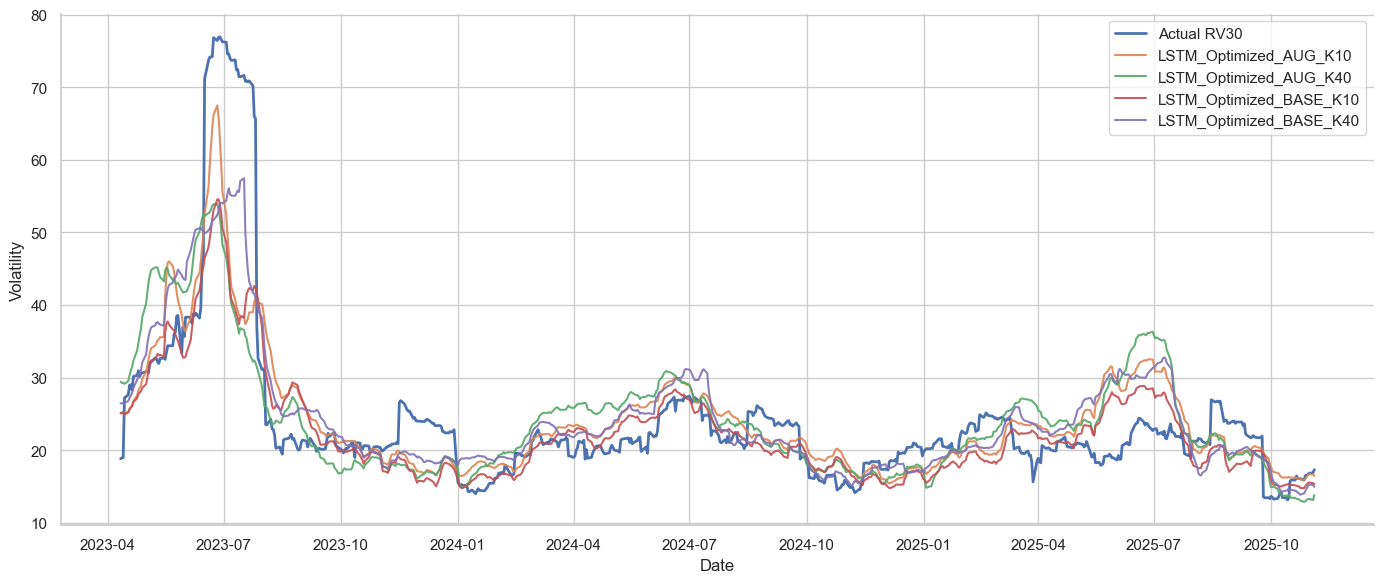

In [60]:
# Train Optimized LSTM models (base vs aug) + compare to baselines
target_col = "Target_RV30"
window = 21

df_all = df_usda.copy().sort_index()
df_all = df_all.loc[:, ~df_all.columns.duplicated()]  # safety

# Keep only numeric columns for LSTM pool, exclude target
numeric_cols = df_all.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != target_col]

# Keep the exact same drop rule used for RF importance
drop_flags = [("PX_" in c) or ("MOV_AVG_" in c) for c in numeric_cols]
cols_to_keep = [c for c, flag in zip(numeric_cols, drop_flags) if not flag]
numeric_cols = cols_to_keep

# Build matrices from the split dataframes
X_train_full = df_train[numeric_cols].values
X_val_full   = df_val[numeric_cols].values
X_test_full  = df_test[numeric_cols].values

y_train_full = df_train[target_col].values
y_val_full   = df_val[target_col].values
y_test_full  = df_test[target_col].values

# Scale X and y 
x_scaler = MinMaxScaler()
X_train_scaled = x_scaler.fit_transform(X_train_full)
X_val_scaled   = x_scaler.transform(X_val_full)
X_test_scaled  = x_scaler.transform(X_test_full)

y_scaler = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = y_scaler.fit_transform(y_train_full.reshape(-1, 1)).ravel()
y_val_scaled   = y_scaler.transform(y_val_full.reshape(-1, 1)).ravel()
y_test_scaled  = y_scaler.transform(y_test_full.reshape(-1, 1)).ravel()

# Baseline aligned series (match LSTM horizon)
actuals_trim = baseline_preds["Actuals"][window:]
dates_aligned = df_test.index[window:]

naive_trim = baseline_preds["Naive_IV"][window:]
econ_trim  = baseline_preds["Linear_Econ"][window:]

# Train Optimized LSTMs (base/aug for K=10 and K=40)
opt_units = 16
opt_dropout = 0.5
Ks_to_eval = [10, 40]

lstm_preds = {}     # key -> pred array aligned to dates_aligned
lstm_metrics = {}   # key -> {MAE, RMSE}
lstm_feats = {}     # key -> feature list

for variant in ["base", "aug"]:
    for K in Ks_to_eval:
        key = f"LSTM_Optimized_{variant.upper()}_K{K}"
        top_feats = feature_sets[(variant, K)]
        lstm_feats[key] = top_feats

        # Map features to indices in numeric_cols
        feat_indices = [numeric_cols.index(f) for f in top_feats]

        # Subset scaled X
        X_train_K = X_train_scaled[:, feat_indices]
        X_val_K   = X_val_scaled[:, feat_indices]
        X_test_K  = X_test_scaled[:, feat_indices]

        # Train+Val merge for final training
        X_trainval_K = np.vstack([X_train_K, X_val_K])
        y_trainval_scaled_K = np.concatenate([y_train_scaled, y_val_scaled])

        # Build sequences
        X_trainval_seq, y_trainval_seq_scaled = make_sequences(X_trainval_K, y_trainval_scaled_K, window)
        X_test_seq,     y_test_seq_scaled     = make_sequences(X_test_K,     y_test_scaled,        window)

        # reproducibility
        try:
            set_global_seed(2026 + (0 if variant == "base" else 1000) + K)
        except Exception:
            pass

        # Build model
        model = Sequential([
            LSTM(opt_units, input_shape=(window, X_trainval_seq.shape[-1])),
            Dropout(opt_dropout),
            Dense(1)
        ])
        model.compile(optimizer="adam", loss="mse")

        es = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

        # Small internal split for early stopping
        split_idx = int(0.9 * len(X_trainval_seq))
        X_tr, X_v = X_trainval_seq[:split_idx], X_trainval_seq[split_idx:]
        y_tr, y_v = y_trainval_seq_scaled[:split_idx], y_trainval_seq_scaled[split_idx:]

        model.fit(
            X_tr, y_tr,
            validation_data=(X_v, y_v),
            epochs=100,
            batch_size=32,
            callbacks=[es],
            verbose=0
        )

        # Predict on test, inverse transform
        y_pred_test_scaled = model.predict(X_test_seq, verbose=0).ravel()
        y_pred_test = y_scaler.inverse_transform(y_pred_test_scaled.reshape(-1, 1)).ravel()

        # Sanity: align to baseline trimmed horizon
        if len(y_pred_test) != len(actuals_trim):
            raise ValueError(f"{key}: length mismatch pred={len(y_pred_test)} vs actuals_trim={len(actuals_trim)}")

        lstm_preds[key] = y_pred_test
        lstm_metrics[key] = {
            "MAE": mean_absolute_error(actuals_trim, y_pred_test),
            "RMSE": rmse(actuals_trim, y_pred_test),
        }

        print(f"{key} | MAE={lstm_metrics[key]['MAE']:.4f} | RMSE={lstm_metrics[key]['RMSE']:.4f}")

# Comparison table (baselines + LSTMs)
rows = []

# Baselines (trimmed to match LSTM horizon)
rows.append({
    "Model": "Naive_IV",
    "MAE": mean_absolute_error(actuals_trim, naive_trim),
    "RMSE": rmse(actuals_trim, naive_trim),
})
rows.append({
    "Model": "Linear_Econ",
    "MAE": mean_absolute_error(actuals_trim, econ_trim),
    "RMSE": rmse(actuals_trim, econ_trim),
})

# LSTMs
for key, m in lstm_metrics.items():
    rows.append({"Model": key, "MAE": m["MAE"], "RMSE": m["RMSE"]})

results_df = pd.DataFrame(rows).sort_values("MAE").reset_index(drop=True)
print("\nTest Performance (aligned, sorted by MAE)")
print(results_df)

# Plot: Target + LSTM models 
plt.figure(figsize=(14, 6))
plt.plot(dates_aligned, actuals_trim, label="Actual RV30", linewidth=2)

for key in sorted(lstm_preds.keys()):
    plt.plot(dates_aligned, lstm_preds[key], label=key, alpha=0.9)

# plt.title("Test Set: Actual RV30 vs Optimized LSTM Models (Aligned after 21-day lookback)")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.tight_layout()
plt.savefig("figs/ablationusda.png", dpi=300, bbox_inches='tight')

plt.show()


---